#Ejercicio Volúmenes de Ventas con Matplotlib
En este ejercicio trabajaremos con un dataset sobre volúmenes de ventas de productos por diferentes canales para diferentes clientes. Realizaremos diferentes tipos de gráficas para responder a ciertas preguntas.  
Para ello primero importamos las librerías necesarias y el dataset. De este último eliminamos los registros con valores nulos (si existen) en alguna de las columnas.
Cabe mencionar que importamos el dataset por chunks con el fin de que el importado sea más rápido. Además, se eliminan ciertas columnas que no nos serán necesarias en el desarrollo de la práctica.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [7]:
# Especificar el tipo de datos de las columnas para un menor coste computacional
dtypes = {'COUNTRY': str, 'GEOGRAPHY': str, 'CUSTOMER': str, 'SEGMENT/CHANNEL': str, 'PRODUCT': str, 'YEAR': int, 'WEEK': int, 'SCENARIO': str, 'SCENARIO_LVL_2': str, 'AMOUNT': float, 'MODEL_ID': float, 'MODEL_CAT': str, 'DEFAULT_MODEL': int, 'FORECAST_YEAR': float, 'FORECAST': str, 'UNIT': str}

# Tamaño del chunk para leer el archivo en partes
chunksize = 10000

# Lista para almacenar los chunks
chunks = []
# Leer el archivo CSV en chunks y aplicar los tipos de datos especificados
for chunk in pd.read_csv('volume_us_forecast_sample.csv', chunksize=chunksize, dtype=dtypes):
    chunks.append(chunk)

# Concatenar los chunks en un solo DataFrame
df = pd.concat(chunks, axis=0)
df = df.drop(columns=['COUNTRY','GEOGRAPHY','SCENARIO_LVL_2','MODEL_CAT','DEFAULT_MODEL','UNIT','AMOUNT_WITHOUT_OUTLIERS'])
df.head()

CUSTOMER SEGMENT/CHANNEL PRODUCT  YEAR  WEEK     SCENARIO    AMOUNT  \
0  AO_FTN_US         CG3_Z59   L2488  2023    20  AI_forecast -5.084845   
1  AO_FTN_US         CG3_Z59   L2488  2023    21  AI_forecast  9.696815   
2  AO_FTN_US         CG3_Z59   L2488  2023    22  AI_forecast -5.896414   
3  AO_FTN_US         CG3_Z59   L2488  2023    23  AI_forecast  0.544680   
4  AO_FTN_US         CG3_Z59   L2488  2023    24  AI_forecast  8.710286   

   MODEL_ID  FORECAST_YEAR FORECAST  
0       1.0         2023.0     W12F  
1       1.0         2023.0     W12F  
2       1.0         2023.0     W12F  
3       1.0         2023.0     W12F  
4       1.0         2023.0     W12F

##Pregunta 1
*¿Cuáles son las 5 combinaciones de canal-producto con más volumen de cada customer?*
Para responder a esta pregunta primero modificamos el dataset eliminando los valores negativos del amount (no tienen sentido) y cambiándolos todos por cero. Posteriormente, dividimos el dataset en función del escenario. Por una parte, los actuals (valores reales) y, por otra parte, los AI_forecast (predicciones de los modelos).

In [8]:
# Reemplazar los valores negativos en la columna 'AMOUNT' por 0
df['AMOUNT'] = df['AMOUNT'].apply(lambda x: 0 if x < 0 else x)

In [9]:
# Crear un nuevo DataFrame con registros donde SCENARIO es igual a 'actual'
df_actual = df[df['SCENARIO'] == 'actual']

# Crear un nuevo DataFrame con registros donde SCENARIO es igual a 'AI_forecast'
df_forecast = df[df['SCENARIO'] == 'AI_forecast']

print(df_actual.head())
print(df_forecast.head())

         CUSTOMER SEGMENT/CHANNEL PRODUCT  YEAR  WEEK SCENARIO      AMOUNT  \
37717  1000006156         CG2_Z19   L2263  2022    16   actual  10719.0000   
37718  1000006156         CG2_Z16   L2408  2022    16   actual     88.0000   
37719  1000006156         CG2_Z19   L2426  2022    16   actual    656.6551   
37720  1000006156         CG2_Z16   L2432  2022    16   actual    443.9056   
37721  1000007206         CG2_Z01   L2235  2022    16   actual     60.0000   

       MODEL_ID  FORECAST_YEAR FORECAST  
37717       NaN            NaN      NaN  
37718       NaN            NaN      NaN  
37719       NaN            NaN      NaN  
37720       NaN            NaN      NaN  
37721       NaN            NaN      NaN  
    CUSTOMER SEGMENT/CHANNEL PRODUCT  YEAR  WEEK     SCENARIO    AMOUNT  \
0  AO_FTN_US         CG3_Z59   L2488  2023    20  AI_forecast  0.000000   
1  AO_FTN_US         CG3_Z59   L2488  2023    21  AI_forecast  9.696815   
2  AO_FTN_US         CG3_Z59   L2488  2023    22  AI_f

Ahora, obtenemos los clientes y cuantos registros hay en la base de datos para cada uno. Esto es para un uso posterior y pequeño análisis del dataframe.

In [10]:
# Obtener los valores únicos de CUSTOMER y contar el número de registros para cada uno
customer_value_counts = df_actual['CUSTOMER'].value_counts()
# Obtener los valores únicos de CUSTOMER
unique_customers = df['CUSTOMER'].unique()

# Mostrar los valores únicos y el número de registros asociados a cada cliente
print(customer_value_counts)

1000006156    153725
AO_FTN_US      72358
1000007206     67639
1000008742     43615
1000007013     26884
Name: CUSTOMER, dtype: int64


Posteriormente, para una visualización más gráfica, realizamos un piechart con el fin de diferenciar tamaños de registros de cada cliente.

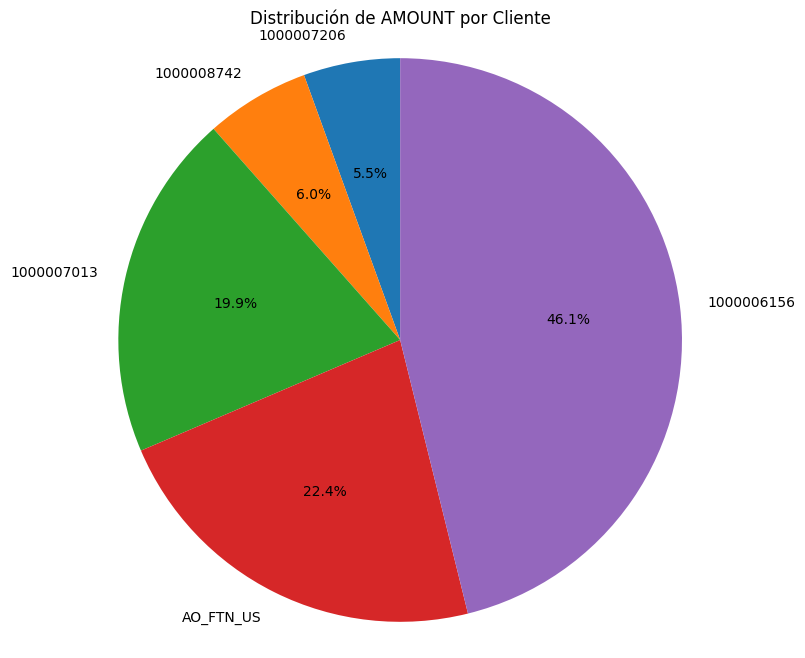

In [11]:
# Agrupar los datos por cliente y calcular la suma del AMOUNT
customer_amount = df_actual.groupby('CUSTOMER')['AMOUNT'].sum().reset_index()

# Ordenar los datos por el AMOUNT en orden descendente para visualizar mejor los clientes con mayor volumen
customer_amount = customer_amount.sort_values(by='AMOUNT', ascending=True)

# Crear el gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(customer_amount['AMOUNT'], labels=customer_amount['CUSTOMER'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Hace que el gráfico de pastel sea un círculo perfecto
plt.title('Distribución de AMOUNT por Cliente')
plt.show()

Realizamos también un diagrama de barras para un mayor entendimiento y conocimiento (aproximado) de los valores (aunque ya los hayamos visto antes).

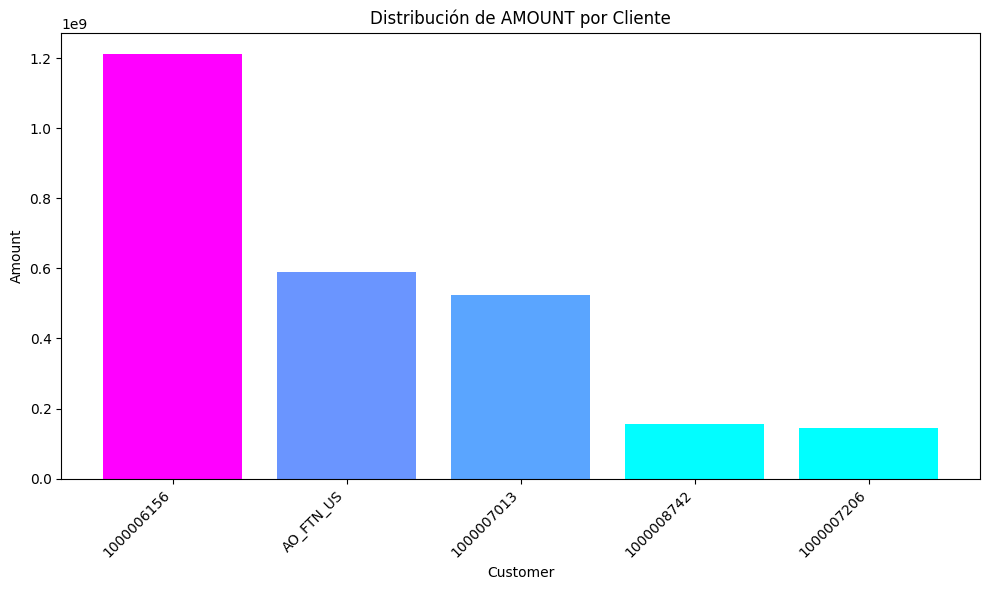

In [12]:
# Ordenar los datos por el AMOUNT en orden descendente para visualizar mejor los clientes con mayor volumen
customer_amount = customer_amount.sort_values(by='AMOUNT', ascending=False)

#Diagrama de barras
normalize = plt.Normalize(vmin=min(customer_amount['AMOUNT']), vmax=max(customer_amount['AMOUNT']))
colormap = plt.cm.cool
colors = colormap(normalize(customer_amount['AMOUNT']))

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(customer_amount['CUSTOMER'], customer_amount['AMOUNT'], color=colors)
plt.xlabel('Customer')
plt.ylabel('Amount')
plt.title('Distribución de AMOUNT por Cliente')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Se puede observar por ambas gráficas que hay gran diferencia en la cantidad de datos. Esto se puede deber a la cantidad de diferentes productos y/o canales de cada cliente. No obstante, no nos afecta en el desarrollo de la práctica por lo que continuamos con la primera pregunta.  
Para continuar, realizamos un agrupamiento de los datos por
```
['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT']
```
realizando la suma de los valores que pertenezcan al mismo grupo. De esta forma podemos, realizando otro agrupamiento por

```
['CUSTOMER', 'AMOUNT']
```
sin realizar ninguna operación, obtener para cada cliente los 5 grupos con mayor volumen de ventas.


In [13]:
# Agrupar por cliente, canal, producto y calcular el volumen total
grouped = df_actual.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT'])['AMOUNT'].sum().reset_index()

# Ordenar los valores dentro de cada grupo por volumen en orden descendente
grouped = grouped.sort_values(by=['CUSTOMER', 'AMOUNT'], ascending=[True, False]).reset_index(drop=True)

# Obtener las 5 combinaciones de canal-producto con más volumen para cada cliente
top_5_combinations = grouped.groupby('CUSTOMER').head(5)

# Mostrar el resultado
print(top_5_combinations.reset_index(drop=True))

      CUSTOMER SEGMENT/CHANNEL PRODUCT        AMOUNT
0   1000006156         CG2_Z19   L2296  2.411632e+08
1   1000006156         CG2_Z19   L2254  2.243821e+08
2   1000006156         CG2_Z19   L2306  1.116108e+08
3   1000006156         CG2_Z19   L2291  8.861778e+07
4   1000006156         CG2_Z19   L2315  6.559889e+07
5   1000007013         CG2_Z30   L2254  2.212933e+08
6   1000007013         CG2_Z30   L2300  1.595024e+08
7   1000007013         CG2_Z30   L2381  4.276457e+07
8   1000007013         CG2_Z30   L2313  1.971886e+07
9   1000007013         CG2_Z30   L2264  1.677616e+07
10  1000007206         CG2_Z01   L2350  3.769028e+07
11  1000007206         CG2_Z01   L2311  2.306756e+07
12  1000007206         CG2_Z01   L2266  1.292130e+07
13  1000007206         CG2_Z01   L2253  1.060424e+07
14  1000007206         CG2_Z01   L2315  9.737771e+06
15  1000008742         CG2_Z08   L2253  2.649091e+07
16  1000008742         CG2_Z08   L2306  2.574832e+07
17  1000008742         CG2_Z08   L2291  2.0786

Se pueden observar los 5 grupos con mayor volumen para cada cliente. Sin embargo, realicemos un desarrollo más profundo. Primero observemos la naturaleza de los datos. Para ello, agrupamos por el mismo criterio de antes y vemos el tamaño de cada grupo. Este es 4. Dicho tamaño se debe a que para cada combinación hemos obviado (eliminado anteriormente) una columna que nos decía si el volumen correspondía al norte, sur, este o oeste del país de venta del producto. Lo mismo sucede con los datos de forecast.

In [14]:
conteo = df_actual.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT','YEAR','WEEK']).size().reset_index(name='Count')
conteo_fcst = df_forecast.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT','YEAR','WEEK','MODEL_ID','FORECAST_YEAR','FORECAST']).size().reset_index(name='Count')
print(conteo.head())
print(conteo_fcst.head())

     CUSTOMER SEGMENT/CHANNEL PRODUCT  YEAR  WEEK  Count
0  1000006156         CG2_Z01   L2226  2021     1      4
1  1000006156         CG2_Z01   L2226  2021     2      4
2  1000006156         CG2_Z01   L2226  2021     3      4
3  1000006156         CG2_Z01   L2226  2021     4      4
4  1000006156         CG2_Z01   L2226  2021     5      4
     CUSTOMER SEGMENT/CHANNEL PRODUCT  YEAR  WEEK  MODEL_ID  FORECAST_YEAR  \
0  1000006156         CG2_Z01   L2226  2023     1       0.0         2023.0   
1  1000006156         CG2_Z01   L2226  2023     1       1.0         2023.0   
2  1000006156         CG2_Z01   L2226  2023     2       0.0         2023.0   
3  1000006156         CG2_Z01   L2226  2023     2       0.0         2023.0   
4  1000006156         CG2_Z01   L2226  2023     2       1.0         2023.0   

  FORECAST  Count  
0       PF      4  
1       PF      4  
2       PF      4  
3     W01F      4  
4       PF      4  


Ahora, volvamos a responder la pregunta pero de una forma mucho más visual haciendo uso de diagramas de tartas y barras. Empecemos por los de tartas. Para cada cliente se grafican los porcentajes que suponen las combinaciones producto-canal de forma que solo salgan los nombres y porcentajes de los 5 con mayor porcentaje. Con esta gráfica conseguimos ver la diferencia de tamaño para cada combinación producto-canal de cada cliente.

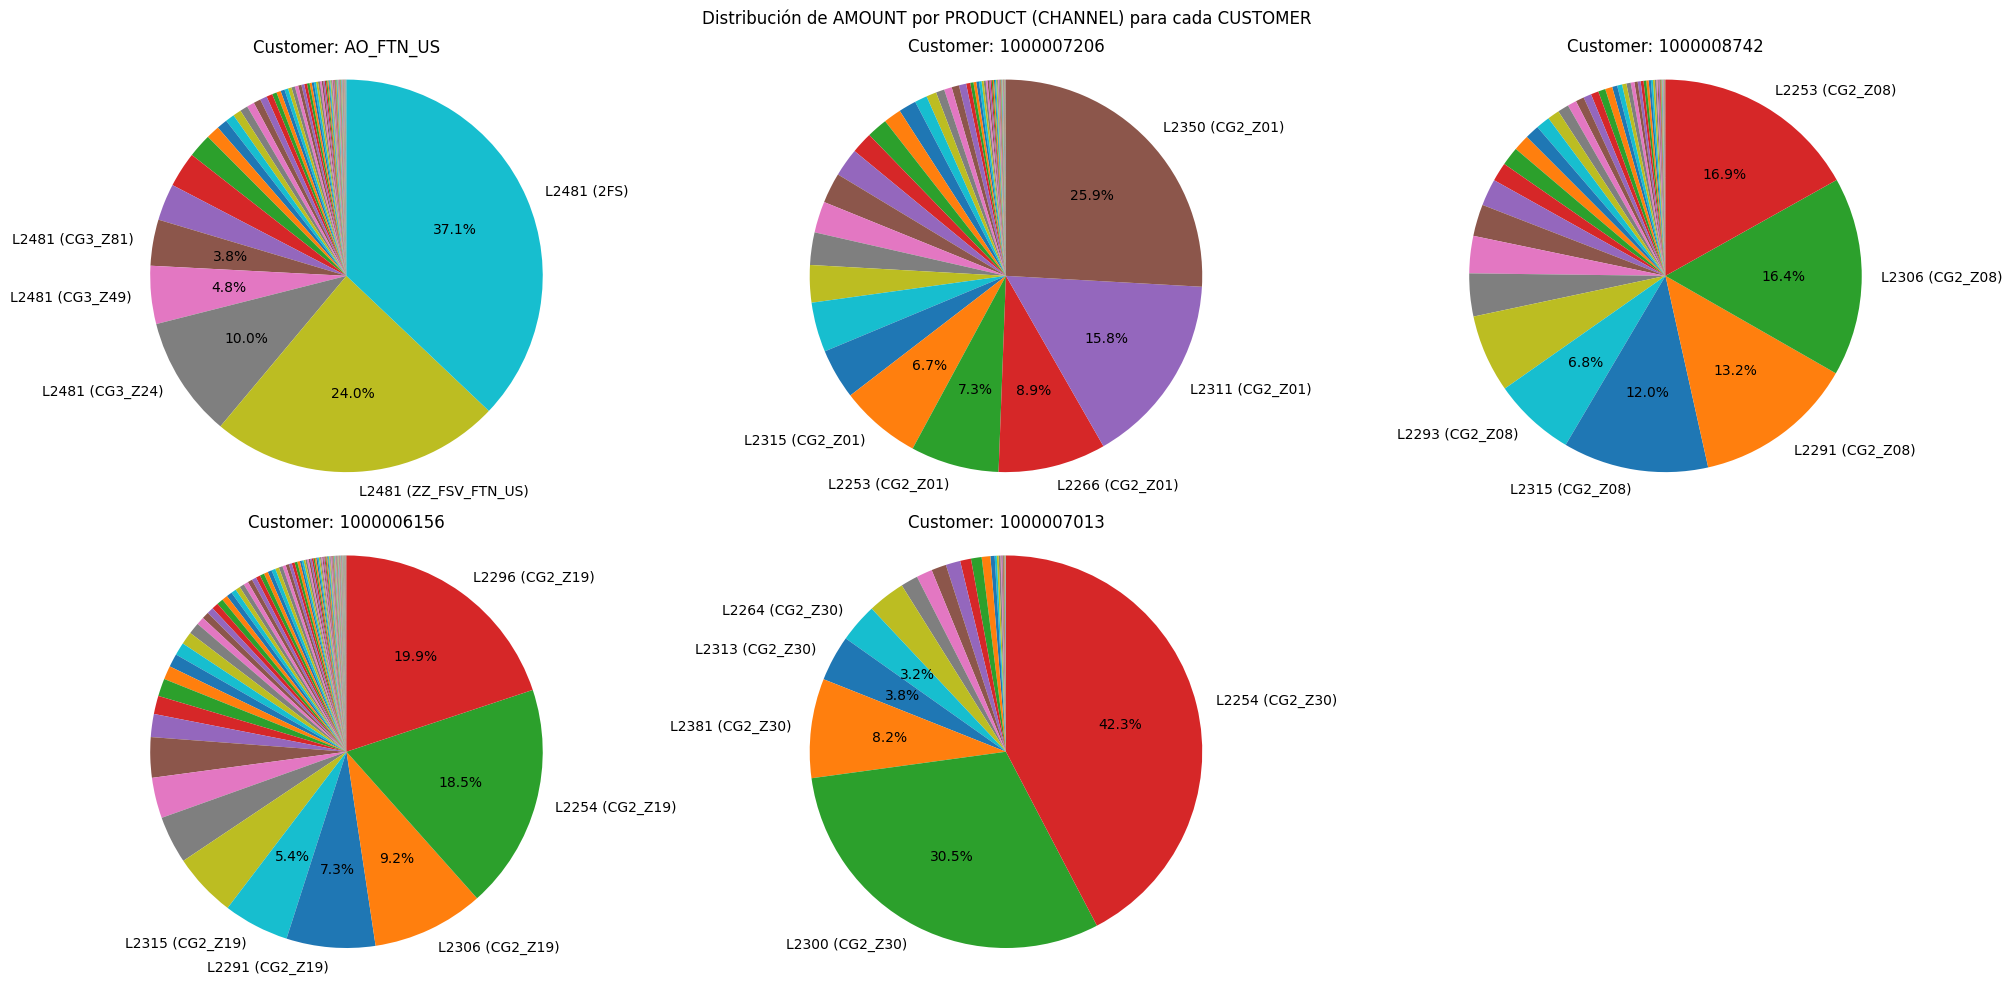

In [15]:
#Función para mostrar unicamente los porcentajes mayores a 5%
def autopct_func(pct, auto_filts):
    return f"{auto_filts.pop(0)}"


# Agrupar los datos por cliente y producto y calcular la suma del AMOUNT
customer_product_amount = df_actual.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT'])['AMOUNT'].sum().reset_index()

# Crear subplots para cada cliente
num_plots = len(unique_customers)
cols = 3  # Número de columnas en la disposición de subplots
rows = (num_plots + cols - 1) // cols  # Cálculo del número de filas necesarias

fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
fig.suptitle('Distribución de AMOUNT por PRODUCT (CHANNEL) para cada CUSTOMER')

for i, customer in enumerate(unique_customers):
    row = i // cols
    col = i % cols
    customer_data = customer_product_amount[customer_product_amount['CUSTOMER'] == customer].sort_values(by='AMOUNT', ascending=True)
    unique_prods  = customer_data['PRODUCT'].unique()
    ax = axs[row, col]

    total_amount = customer_data['AMOUNT'].sum()
    labels = customer_data['PRODUCT']+' ('+customer_data['SEGMENT/CHANNEL']+')'
    sizes = customer_data['AMOUNT']

    # Generar una lista de etiquetas solo para secciones que cumplen el criterio
    #CAMBIAR!!!!!!!!!!!!!!------------
    labels_filt = ['' if i < len(labels)-5 else label for i, label in enumerate(labels)]
    autopct_filt = [f"{(size/total_amount)*100:.1f}%" if i >= len(labels)-5 else '' for i, size in enumerate(sizes)]

    ax.pie(customer_data['AMOUNT'], labels=labels_filt, autopct=lambda pct: autopct_func(pct, autopct_filt), startangle=90)
    ax.axis('equal')  # Hace que el gráfico de pastel sea un círculo perfecto
    ax.set_title(f'Customer: {customer}')

# Eliminar subplots no utilizados
for i in range(len(unique_customers), rows * cols):
    if rows > 1:
        fig.delaxes(axs[i // cols, i % cols])
    else:
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


Ahora, observemos las cantidades por distribución (volumen de ventas) de la misma manera pero con un diagrama de barras. Además, se aplicará un mapa de colores de forma que sea más visual las diferencias por colores. Cabe mencionar que el eje x contiene los productos por lo que para una misma posición en x pueden haber varios valores debido a las diferentes combinaciones producto-canal. Además, en la leyenda se muestran, por órden, las 5 combinaciones con mayor volumen y su color para su identificación en el diagrama.

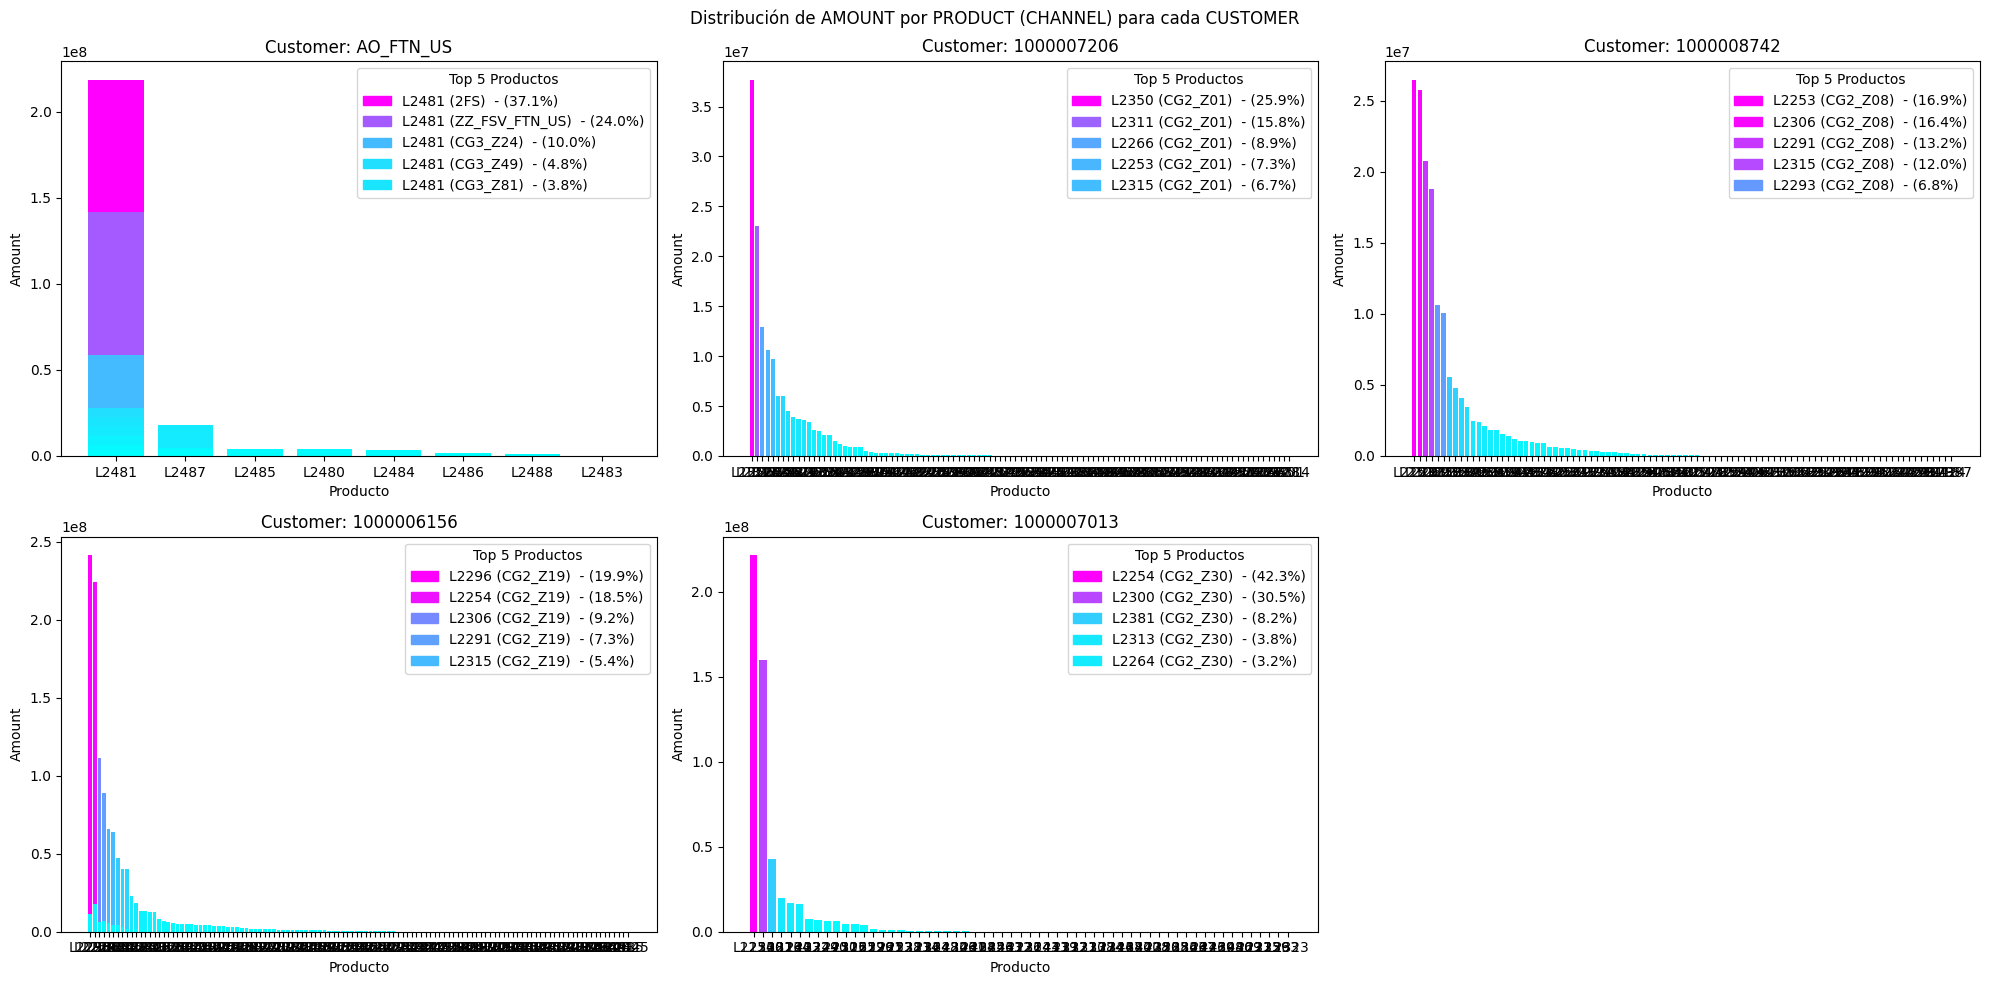

In [16]:
# Agrupar los datos por cliente y producto y calcular la suma del AMOUNT
customer_product_amount = df_actual.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT'])['AMOUNT'].sum().reset_index()

fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
fig.suptitle('Distribución de AMOUNT por PRODUCT (CHANNEL) para cada CUSTOMER')

topcustomers = unique_customers
topproducts = []
topchanels = []

for i, customer in enumerate(unique_customers):
    row = i // cols
    col = i % cols
    customer_data = customer_product_amount[customer_product_amount['CUSTOMER'] == customer].sort_values(by='AMOUNT', ascending=False)
    unique_prods  = customer_data['PRODUCT'].unique()
    ax = axs[row, col]

    total_amount = customer_data['AMOUNT'].sum()
    labels = customer_data['PRODUCT']
    sizes = customer_data['AMOUNT']

    # Generar una lista de etiquetas solo para secciones que cumplen el criterio
    labels_filt = customer_data['PRODUCT'].head(5).values

    #Colormap
    normalize = plt.Normalize(vmin=min(customer_data['AMOUNT']), vmax=max(customer_data['AMOUNT']))
    colormap = plt.cm.cool
    colors = colormap(normalize(customer_data['AMOUNT']))
    top5_colors = colors[:5]
    colors_legend = [plt.Rectangle((0,0),1,1, color=top5_colors[i]) for i in range(5)]

    #Diagrama de barras
    ax.bar(customer_data['PRODUCT'], customer_data['AMOUNT'], color=colors)
    ax.set_title(f'Customer: {customer}')
    ax.set_xlabel('Producto')
    ax.set_ylabel('Amount')


    #Leyenda
    top5_pct = [f"{(size/total_amount)*100:.1f}%" for size in sizes[:5]]
    top5_channel = customer_data['SEGMENT/CHANNEL'].head(5).values
    ax.legend(colors_legend, labels_filt+' ('+top5_channel+') '+' - ('+top5_pct+')', title='Top 5 Productos', loc='upper right')

    topproducts.append(labels_filt)
    topchanels.append(top5_channel)

# Eliminar subplots no utilizados
for i in range(len(unique_customers), rows * cols):
    if rows > 1:
        fig.delaxes(axs[i // cols, i % cols])
    else:
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

Podemos observar como las primeras dos combinaciones canal-producto dominan en casi todos los clientes. Además, se diferencian bien todas las combinaciones.

##Pregunta 2
*Cuál es el error cuadrático medio de cada modelo de las series de la pregunta anterior?*  
Para responder a dicha pregunta, primero vemos cuantos valores hay para combinación CUSTOMER-SEGMENT/CHANNEL-PRODUCT-YEAR-WEEK-MODEL_ID-FORECAST_YEAR añadiendo una columna NumUniqueForecasts para luego dividir entre estos y obtener la media de las predicciones para una misma fecha.

In [17]:
division = conteo_fcst.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT', 'YEAR', 'WEEK', 'MODEL_ID', 'FORECAST_YEAR'])['FORECAST'].nunique().reset_index(name='NumUniqueForecasts')
division.head()

CUSTOMER SEGMENT/CHANNEL PRODUCT  YEAR  WEEK  MODEL_ID  FORECAST_YEAR  \
0  1000006156         CG2_Z01   L2226  2023     1       0.0         2023.0   
1  1000006156         CG2_Z01   L2226  2023     1       1.0         2023.0   
2  1000006156         CG2_Z01   L2226  2023     2       0.0         2023.0   
3  1000006156         CG2_Z01   L2226  2023     2       1.0         2023.0   
4  1000006156         CG2_Z01   L2226  2023     3       0.0         2023.0   

   NumUniqueForecasts  
0                   1  
1                   1  
2                   2  
3                   2  
4                   3

Realizamos las medias creando una nueva columna llamada AMOUNT_DIV.

In [18]:
#customer_product_amount = df_actual.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT'])['AMOUNT'].sum().reset_index()
customer_product_amount_forecast = df_forecast.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT','YEAR','WEEK','MODEL_ID','FORECAST_YEAR'])['AMOUNT'].sum().reset_index()
customer_product_amount_forecast['NumUniqueForecasts'] = division['NumUniqueForecasts']
customer_product_amount_forecast['AMOUNT_DIV'] = customer_product_amount_forecast['AMOUNT']/customer_product_amount_forecast['NumUniqueForecasts']
customer_product_amount_forecast.head()

CUSTOMER SEGMENT/CHANNEL PRODUCT  YEAR  WEEK  MODEL_ID  FORECAST_YEAR  \
0  1000006156         CG2_Z01   L2226  2023     1       0.0         2023.0   
1  1000006156         CG2_Z01   L2226  2023     1       1.0         2023.0   
2  1000006156         CG2_Z01   L2226  2023     2       0.0         2023.0   
3  1000006156         CG2_Z01   L2226  2023     2       1.0         2023.0   
4  1000006156         CG2_Z01   L2226  2023     3       0.0         2023.0   

     AMOUNT  NumUniqueForecasts  AMOUNT_DIV  
0  0.089435                   1    0.089435  
1  0.089435                   1    0.089435  
2  0.122633                   2    0.061317  
3  0.122633                   2    0.061317  
4  1.212503                   3    0.404168

Ahora dividimos el dataset en los dos modelos. Cabe mencionar que ambos son iguales. No se sabe si es un error del dataset o esto debe ser así.

In [19]:
customer_product_amount_forecast_model0 = customer_product_amount_forecast[customer_product_amount_forecast['MODEL_ID']==0]
customer_product_amount_forecast_model1 = customer_product_amount_forecast[customer_product_amount_forecast['MODEL_ID']==1]

Preparamos tambien los datos de actuals agrupando por los mismos valores que los forecast.

In [20]:
customer_product_amount_actual = df_actual.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT','YEAR','WEEK'])['AMOUNT'].sum().reset_index()
customer_product_amount_actual.head()

CUSTOMER SEGMENT/CHANNEL PRODUCT  YEAR  WEEK  AMOUNT
0  1000006156         CG2_Z01   L2226  2021     1    0.00
1  1000006156         CG2_Z01   L2226  2021     2    0.00
2  1000006156         CG2_Z01   L2226  2021     3    0.00
3  1000006156         CG2_Z01   L2226  2021     4    0.00
4  1000006156         CG2_Z01   L2226  2021     5    3.75

Unimos las tres tablas de forma que solo se queden los registros con fechas del amount (tanto real como predicho) comunes para así poder calcular el error cuadrático medio. Cabe mencionar que la operación que se realiza para esto es un inner join. Además, cambiamos los nombres a las columnas para que sean más fácilmente entendibles.

In [21]:
merged_amounts = customer_product_amount_actual.merge(customer_product_amount_forecast_model0, on=['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT','YEAR','WEEK'], how='inner', indicator=True).query('_merge == "both"').drop('_merge', axis=1)
merged_amounts = merged_amounts.merge(customer_product_amount_forecast_model1, on=['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT','YEAR','WEEK'], how='inner', indicator=True).query('_merge == "both"').drop('_merge', axis=1)


nombres = ['CUSTOMER',	'SEGMENT/CHANNEL',	'PRODUCT',	'YEAR',	'WEEK',	'AMOUNT_REAL',	'MODEL_ID_0',	'FORECAST_YEAR_x',	'AMOUNT_0',	'NumUniqueForecasts_0',	'AMOUNT_DIV_0',	'MODEL_ID_1',	'FORECAST_YEAR_y',	'AMOUNT_1',	'NumUniqueForecasts_1',	'AMOUNT_DIV_1']
merged_amounts.columns = nombres
merged_amounts = merged_amounts.drop(columns = ['MODEL_ID_0', 'FORECAST_YEAR_x', 'MODEL_ID_1',	'FORECAST_YEAR_y'])
merged_amounts.sort_values(by=['YEAR', 'WEEK'], ascending=[True, True]).tail()

CUSTOMER SEGMENT/CHANNEL PRODUCT  YEAR  WEEK  AMOUNT_REAL  \
35139  AO_FTN_US   ZZ_FSV_FTN_US   L2484  2023    35   30643.7484   
35174  AO_FTN_US   ZZ_FSV_FTN_US   L2485  2023    35    3773.9614   
35209  AO_FTN_US   ZZ_FSV_FTN_US   L2486  2023    35   50381.4961   
35244  AO_FTN_US   ZZ_FSV_FTN_US   L2487  2023    35   48533.6977   
35279  AO_FTN_US   ZZ_FSV_FTN_US   L2488  2023    35    6107.9373   

          AMOUNT_0  NumUniqueForecasts_0  AMOUNT_DIV_0     AMOUNT_1  \
35139  33165.22300                     1   33165.22300  33165.22300   
35174   2968.31420                     1    2968.31420   2968.31420   
35209  21935.32100                     1   21935.32100  21935.32100   
35244  48844.19830                     1   48844.19830  48844.19830   
35279   8065.60776                     1    8065.60776   8065.60776   

       NumUniqueForecasts_1  AMOUNT_DIV_1  
35139                     1   33165.22300  
35174                     1    2968.31420  
35209                     1   21935.32100  
35244                     1   48844.19830  
35279                     1    8065.60776

Ahora, adelantandonos al ejercicio 3, graficamos las series temporales reales enfrentadas a las predicciones. Con esto podremos intuir cuales serán aquellas series que tengan error cuadrático medio menor de las top5 combinaciones de cada cliente. Para ello creamos un bucle que recorra los clientes. Dentro de este creamos una figura con 5 subplots. Creamos otro bucle que recorra un vector creado anteriormente con las top5 combinaciones ordenadas de cada cliente. Filtramos el dataset y graficamos en una gráfica de lineas.

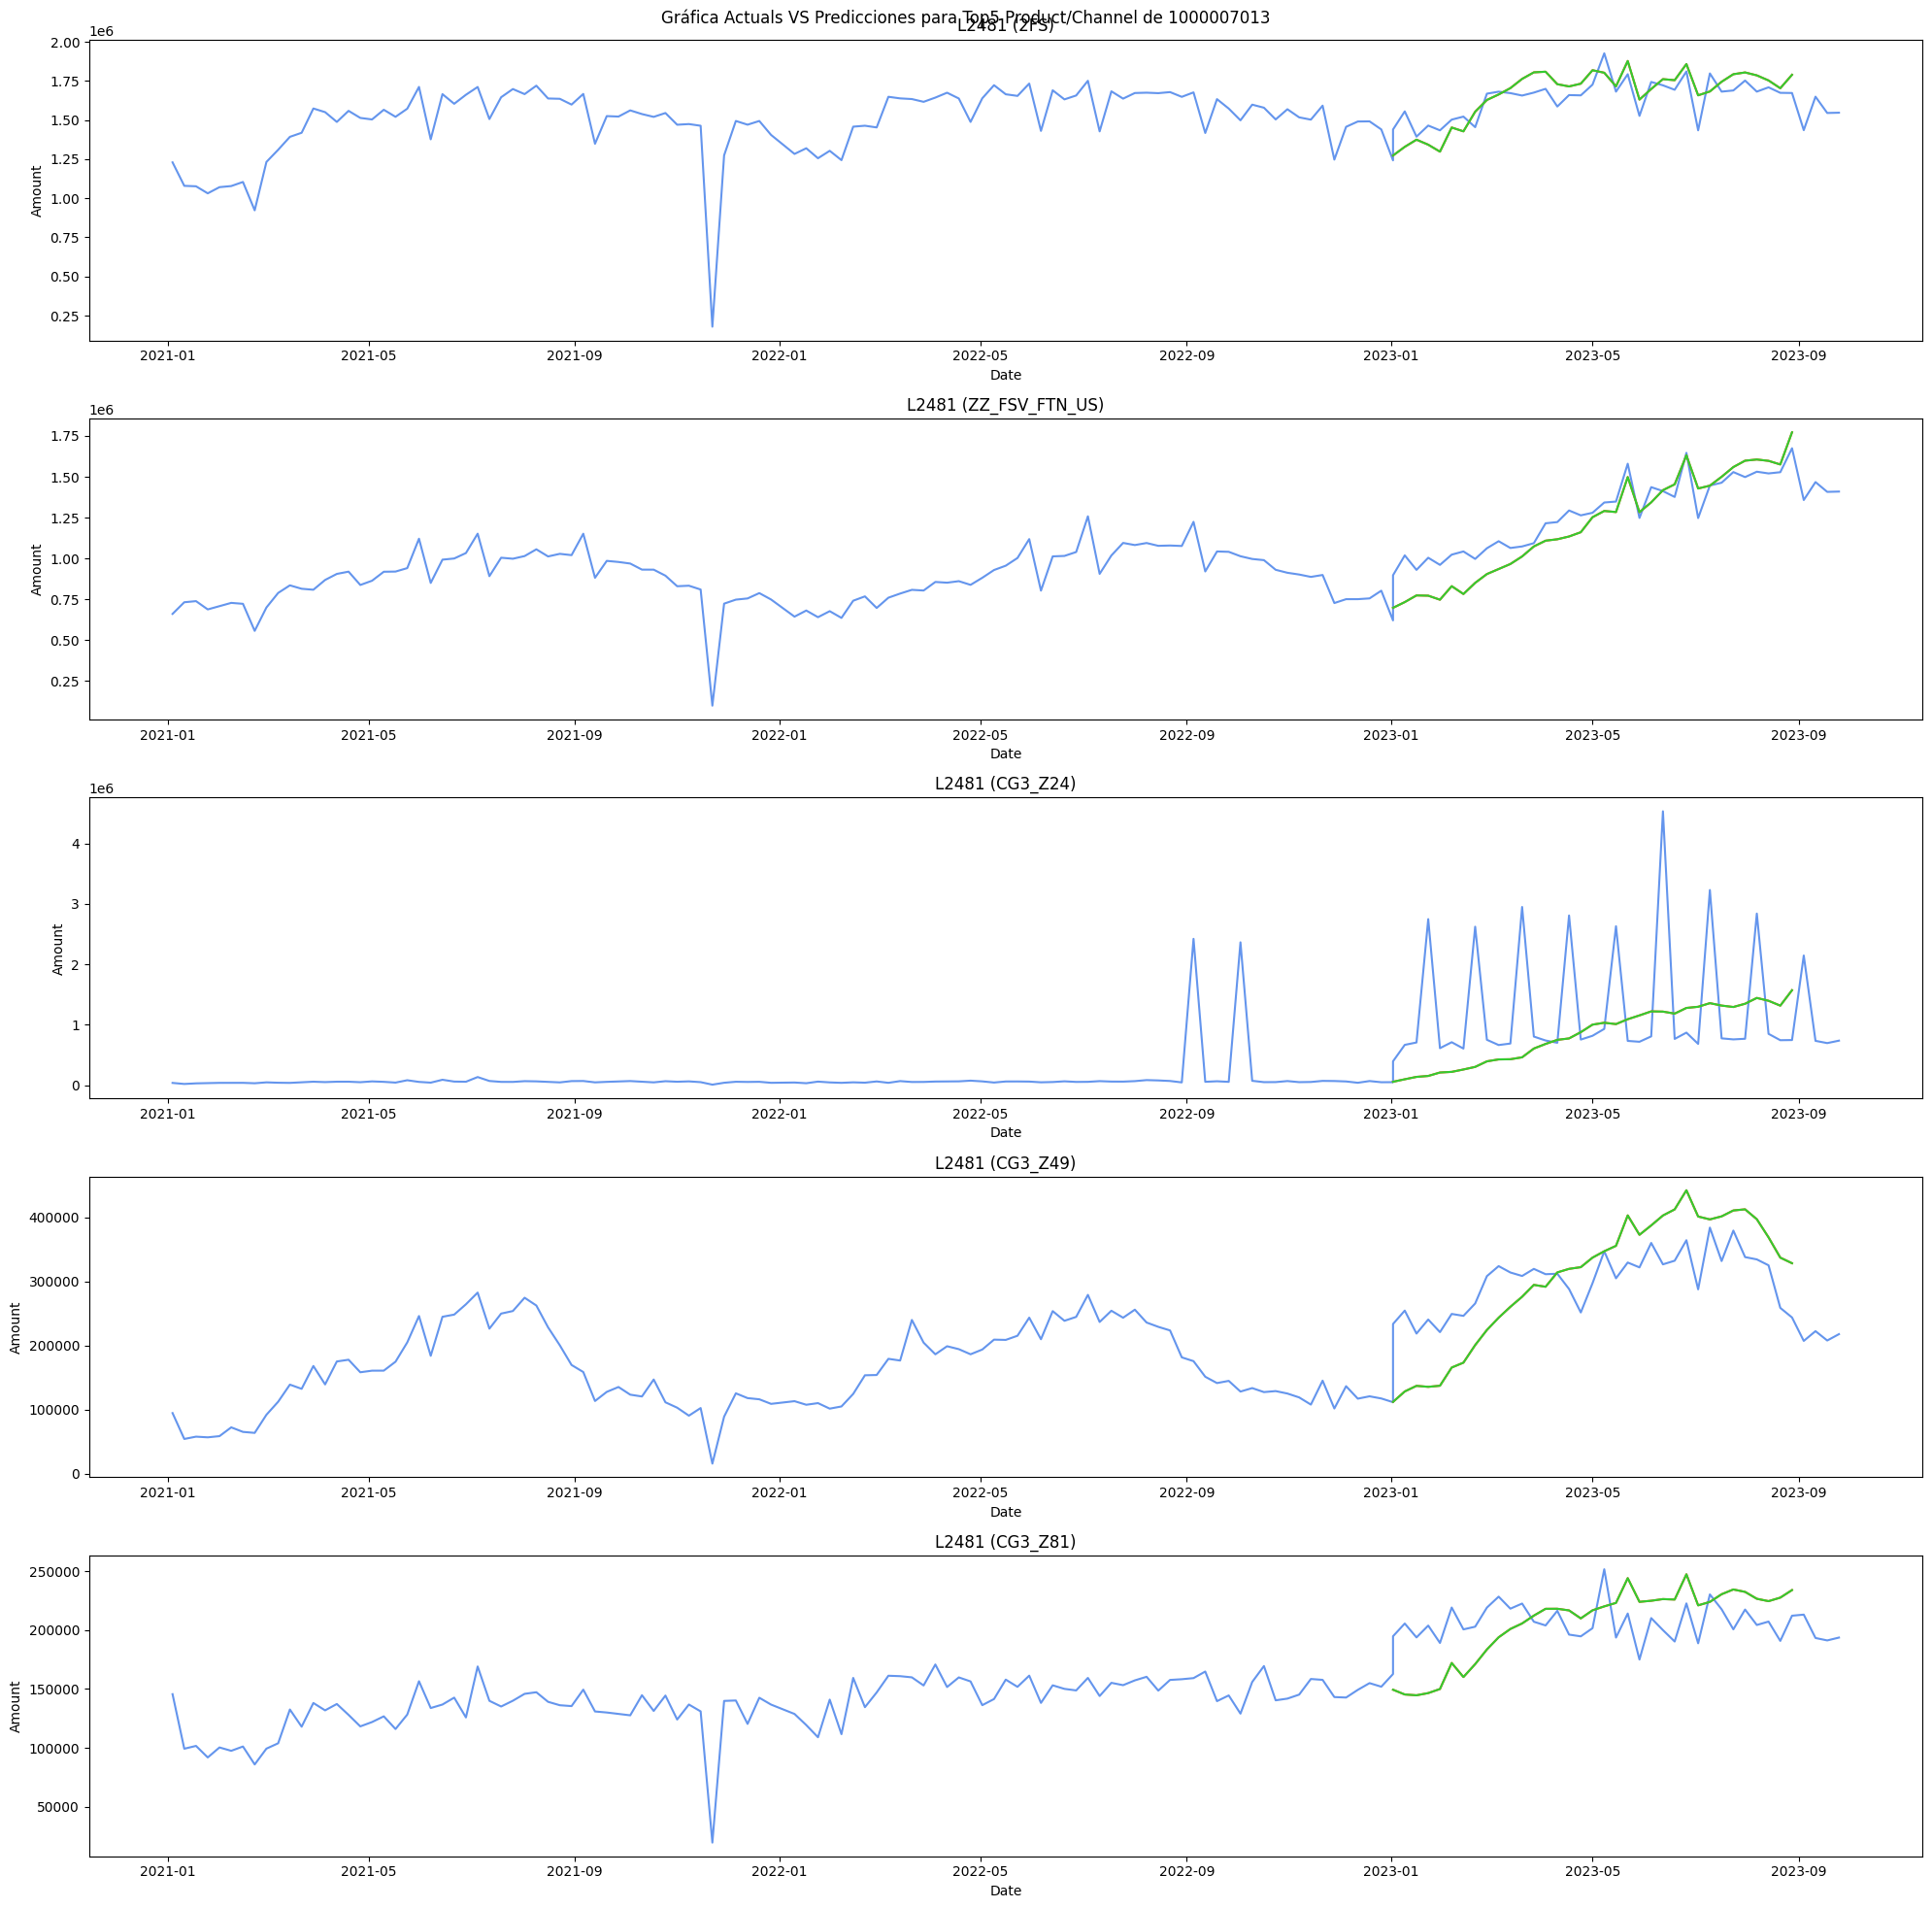

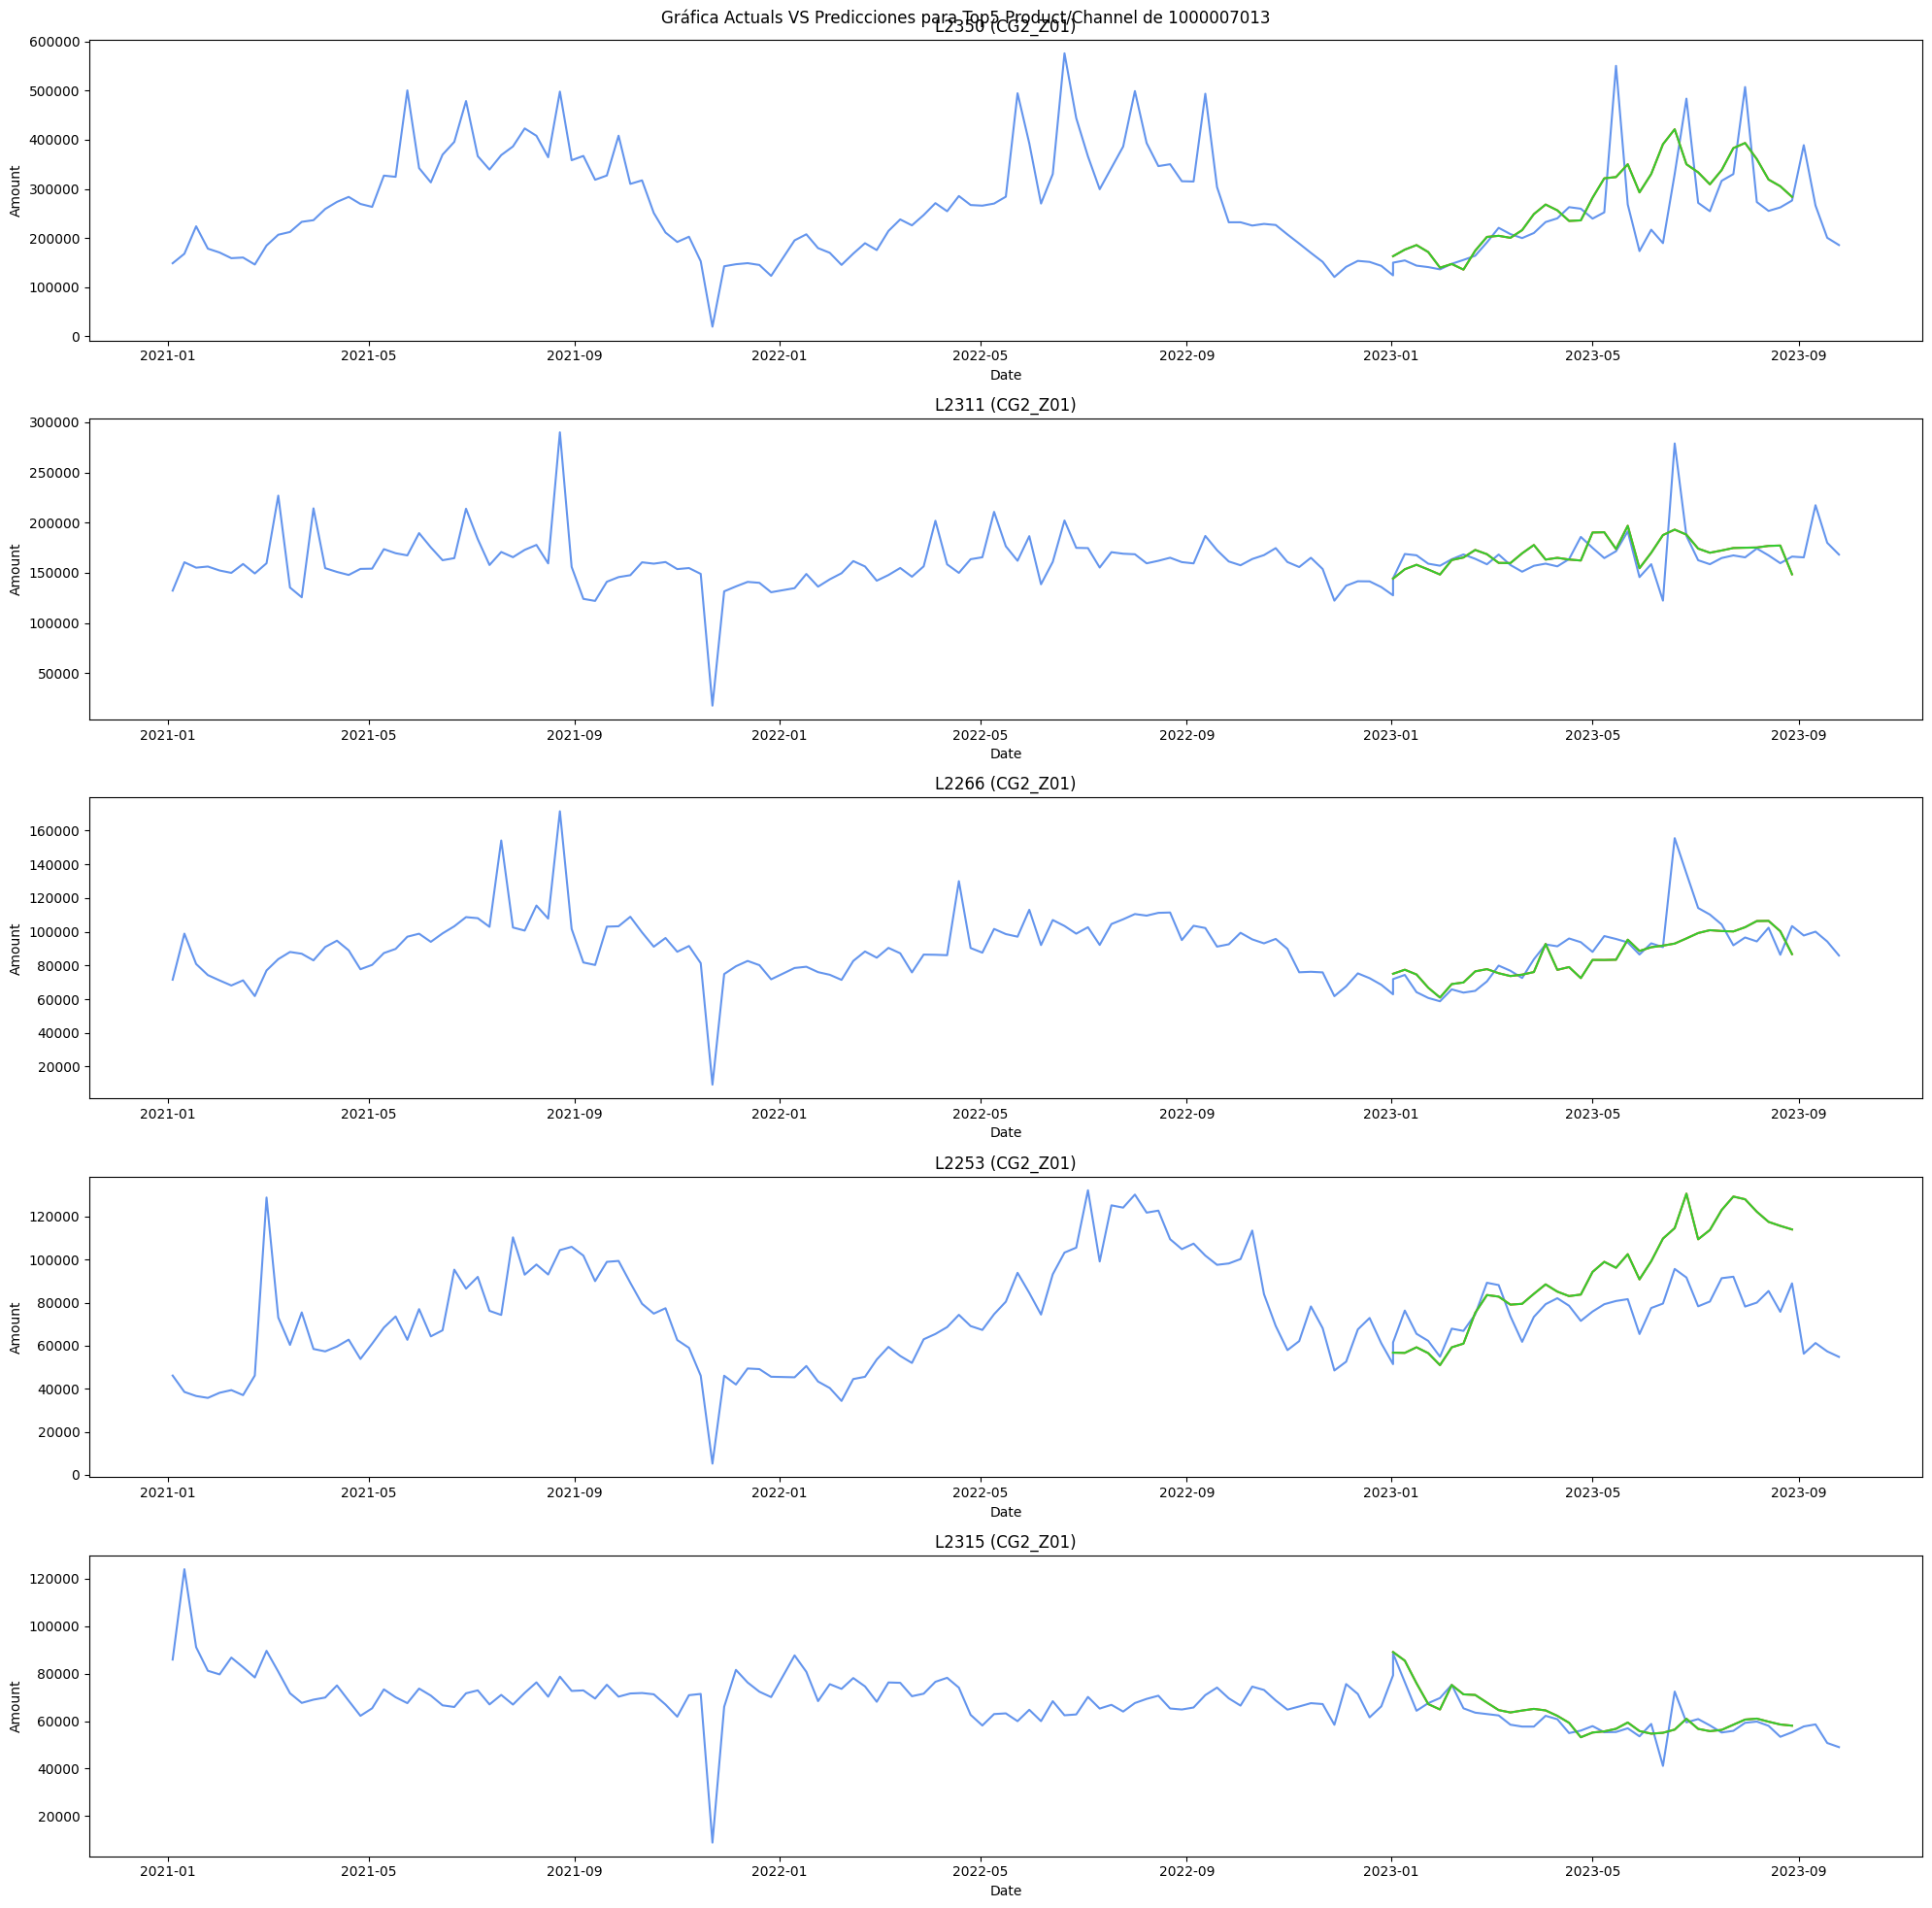

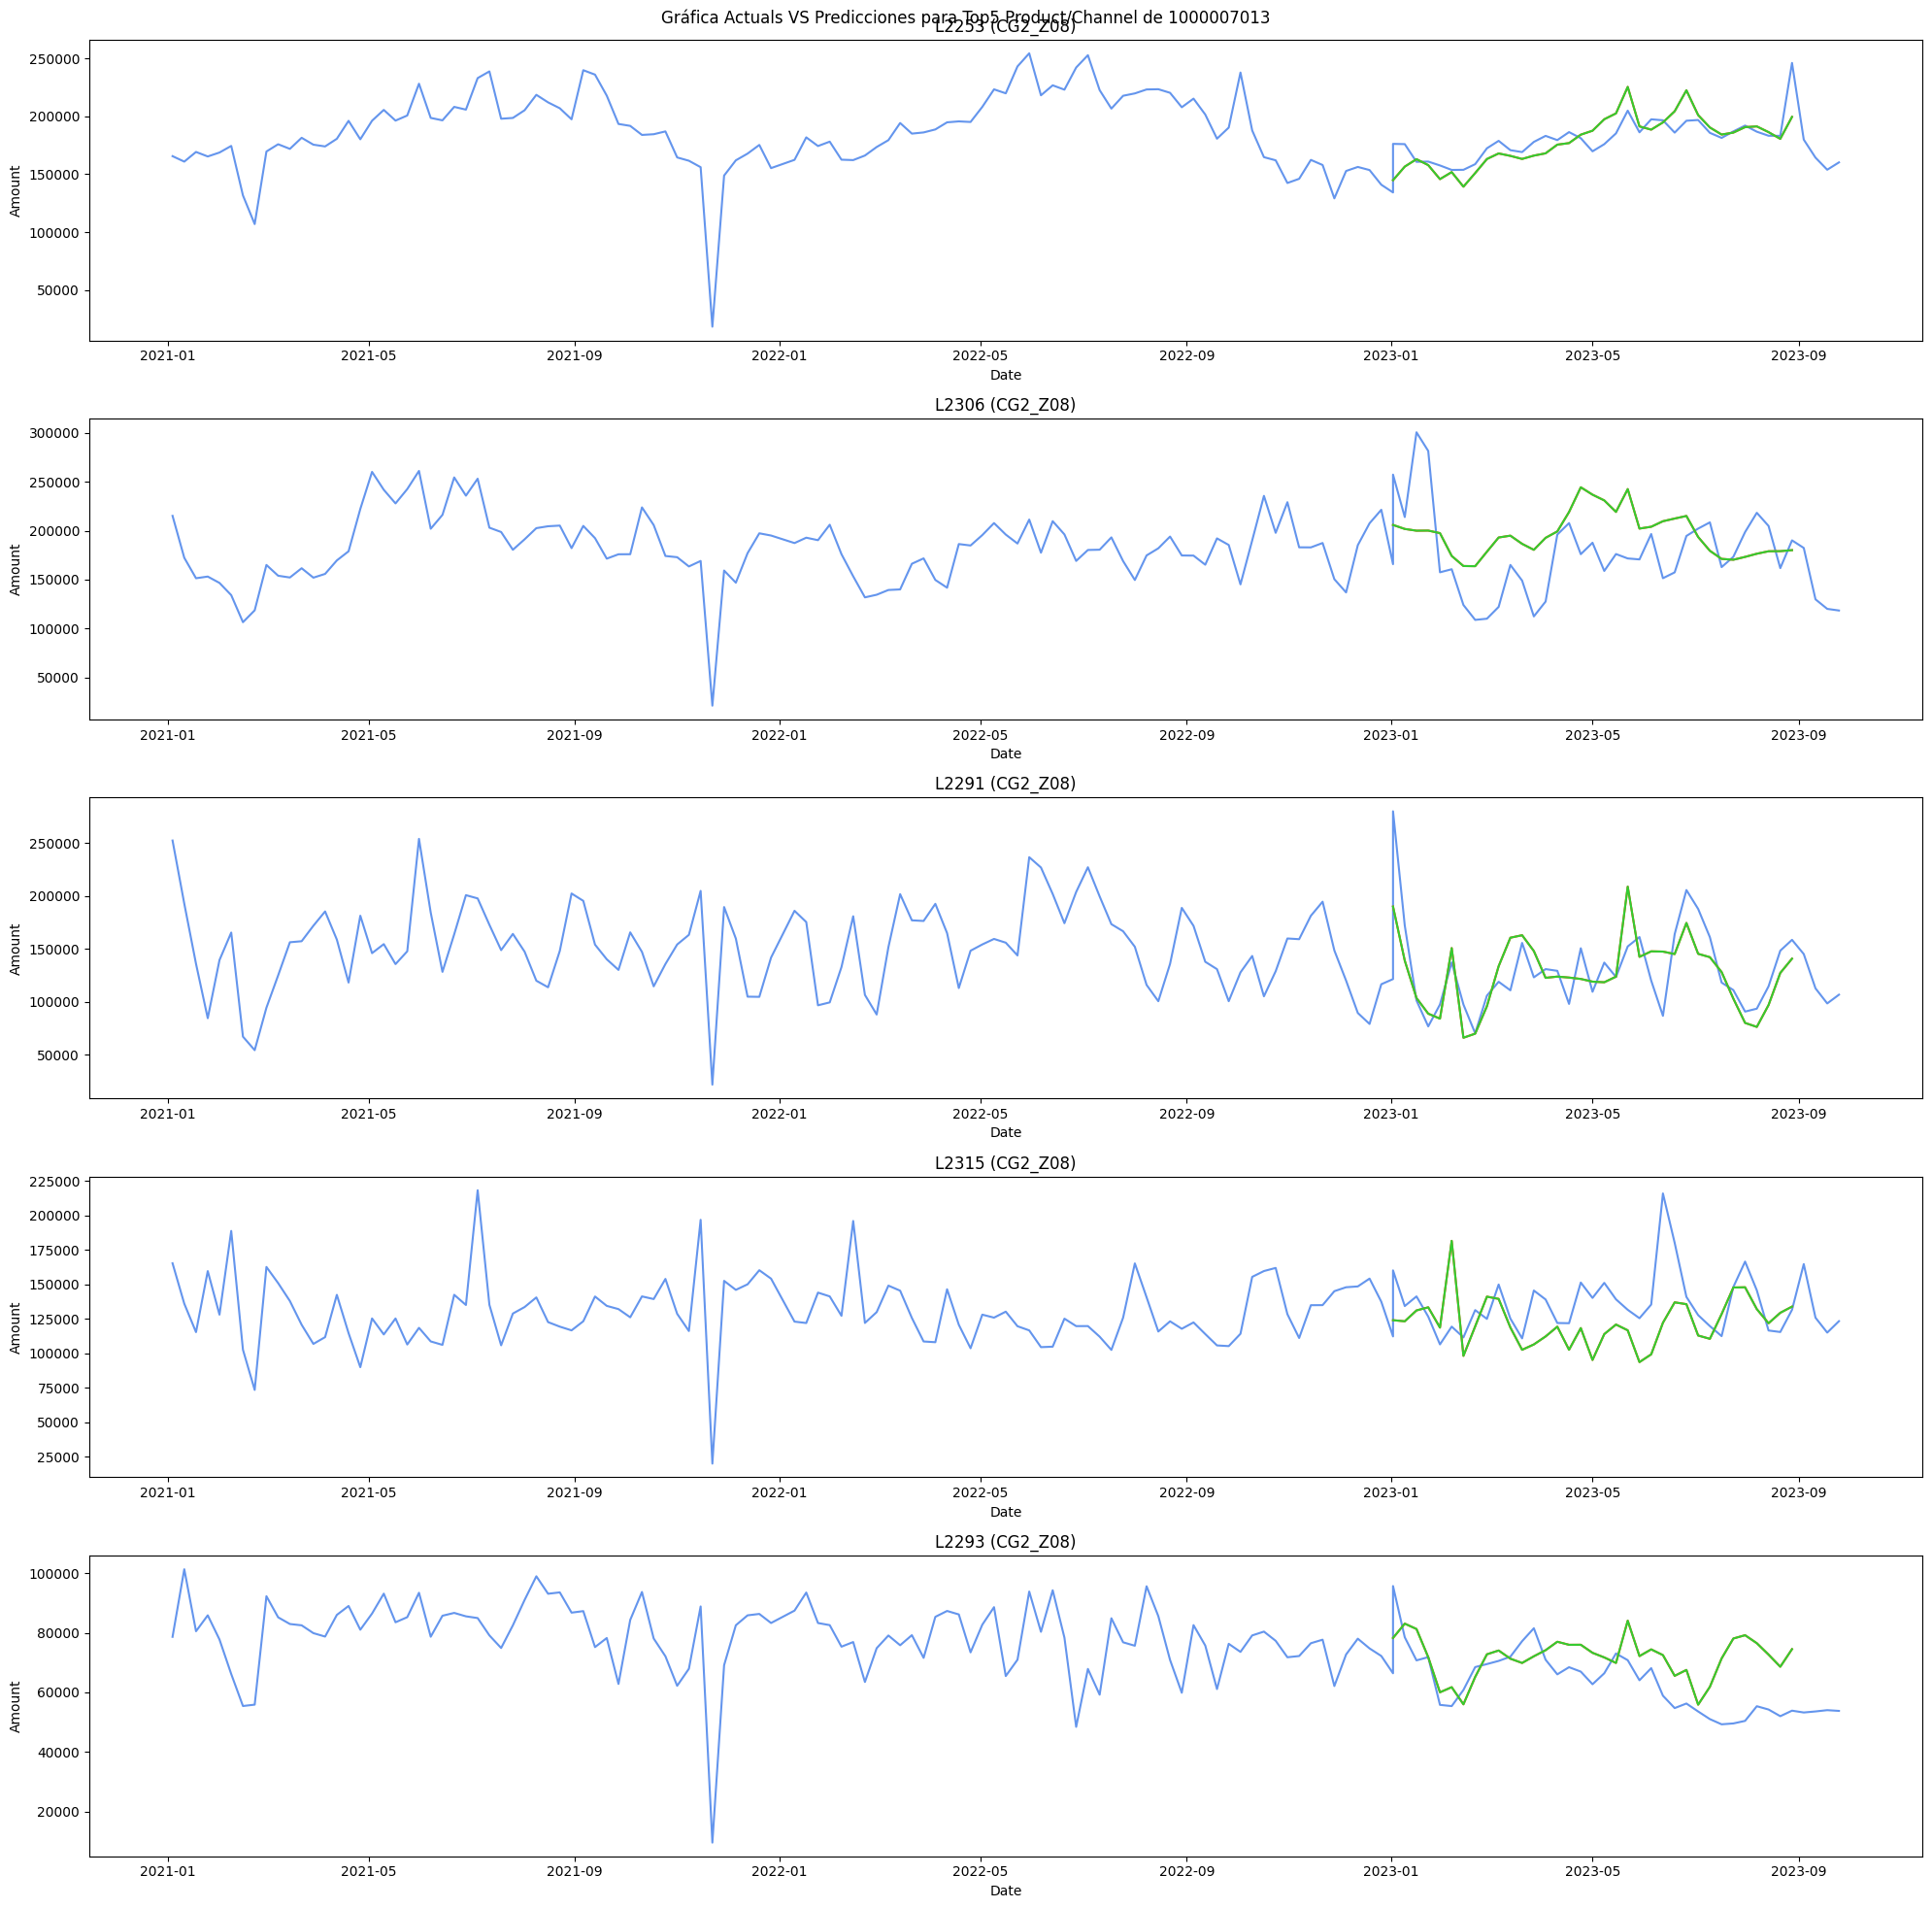

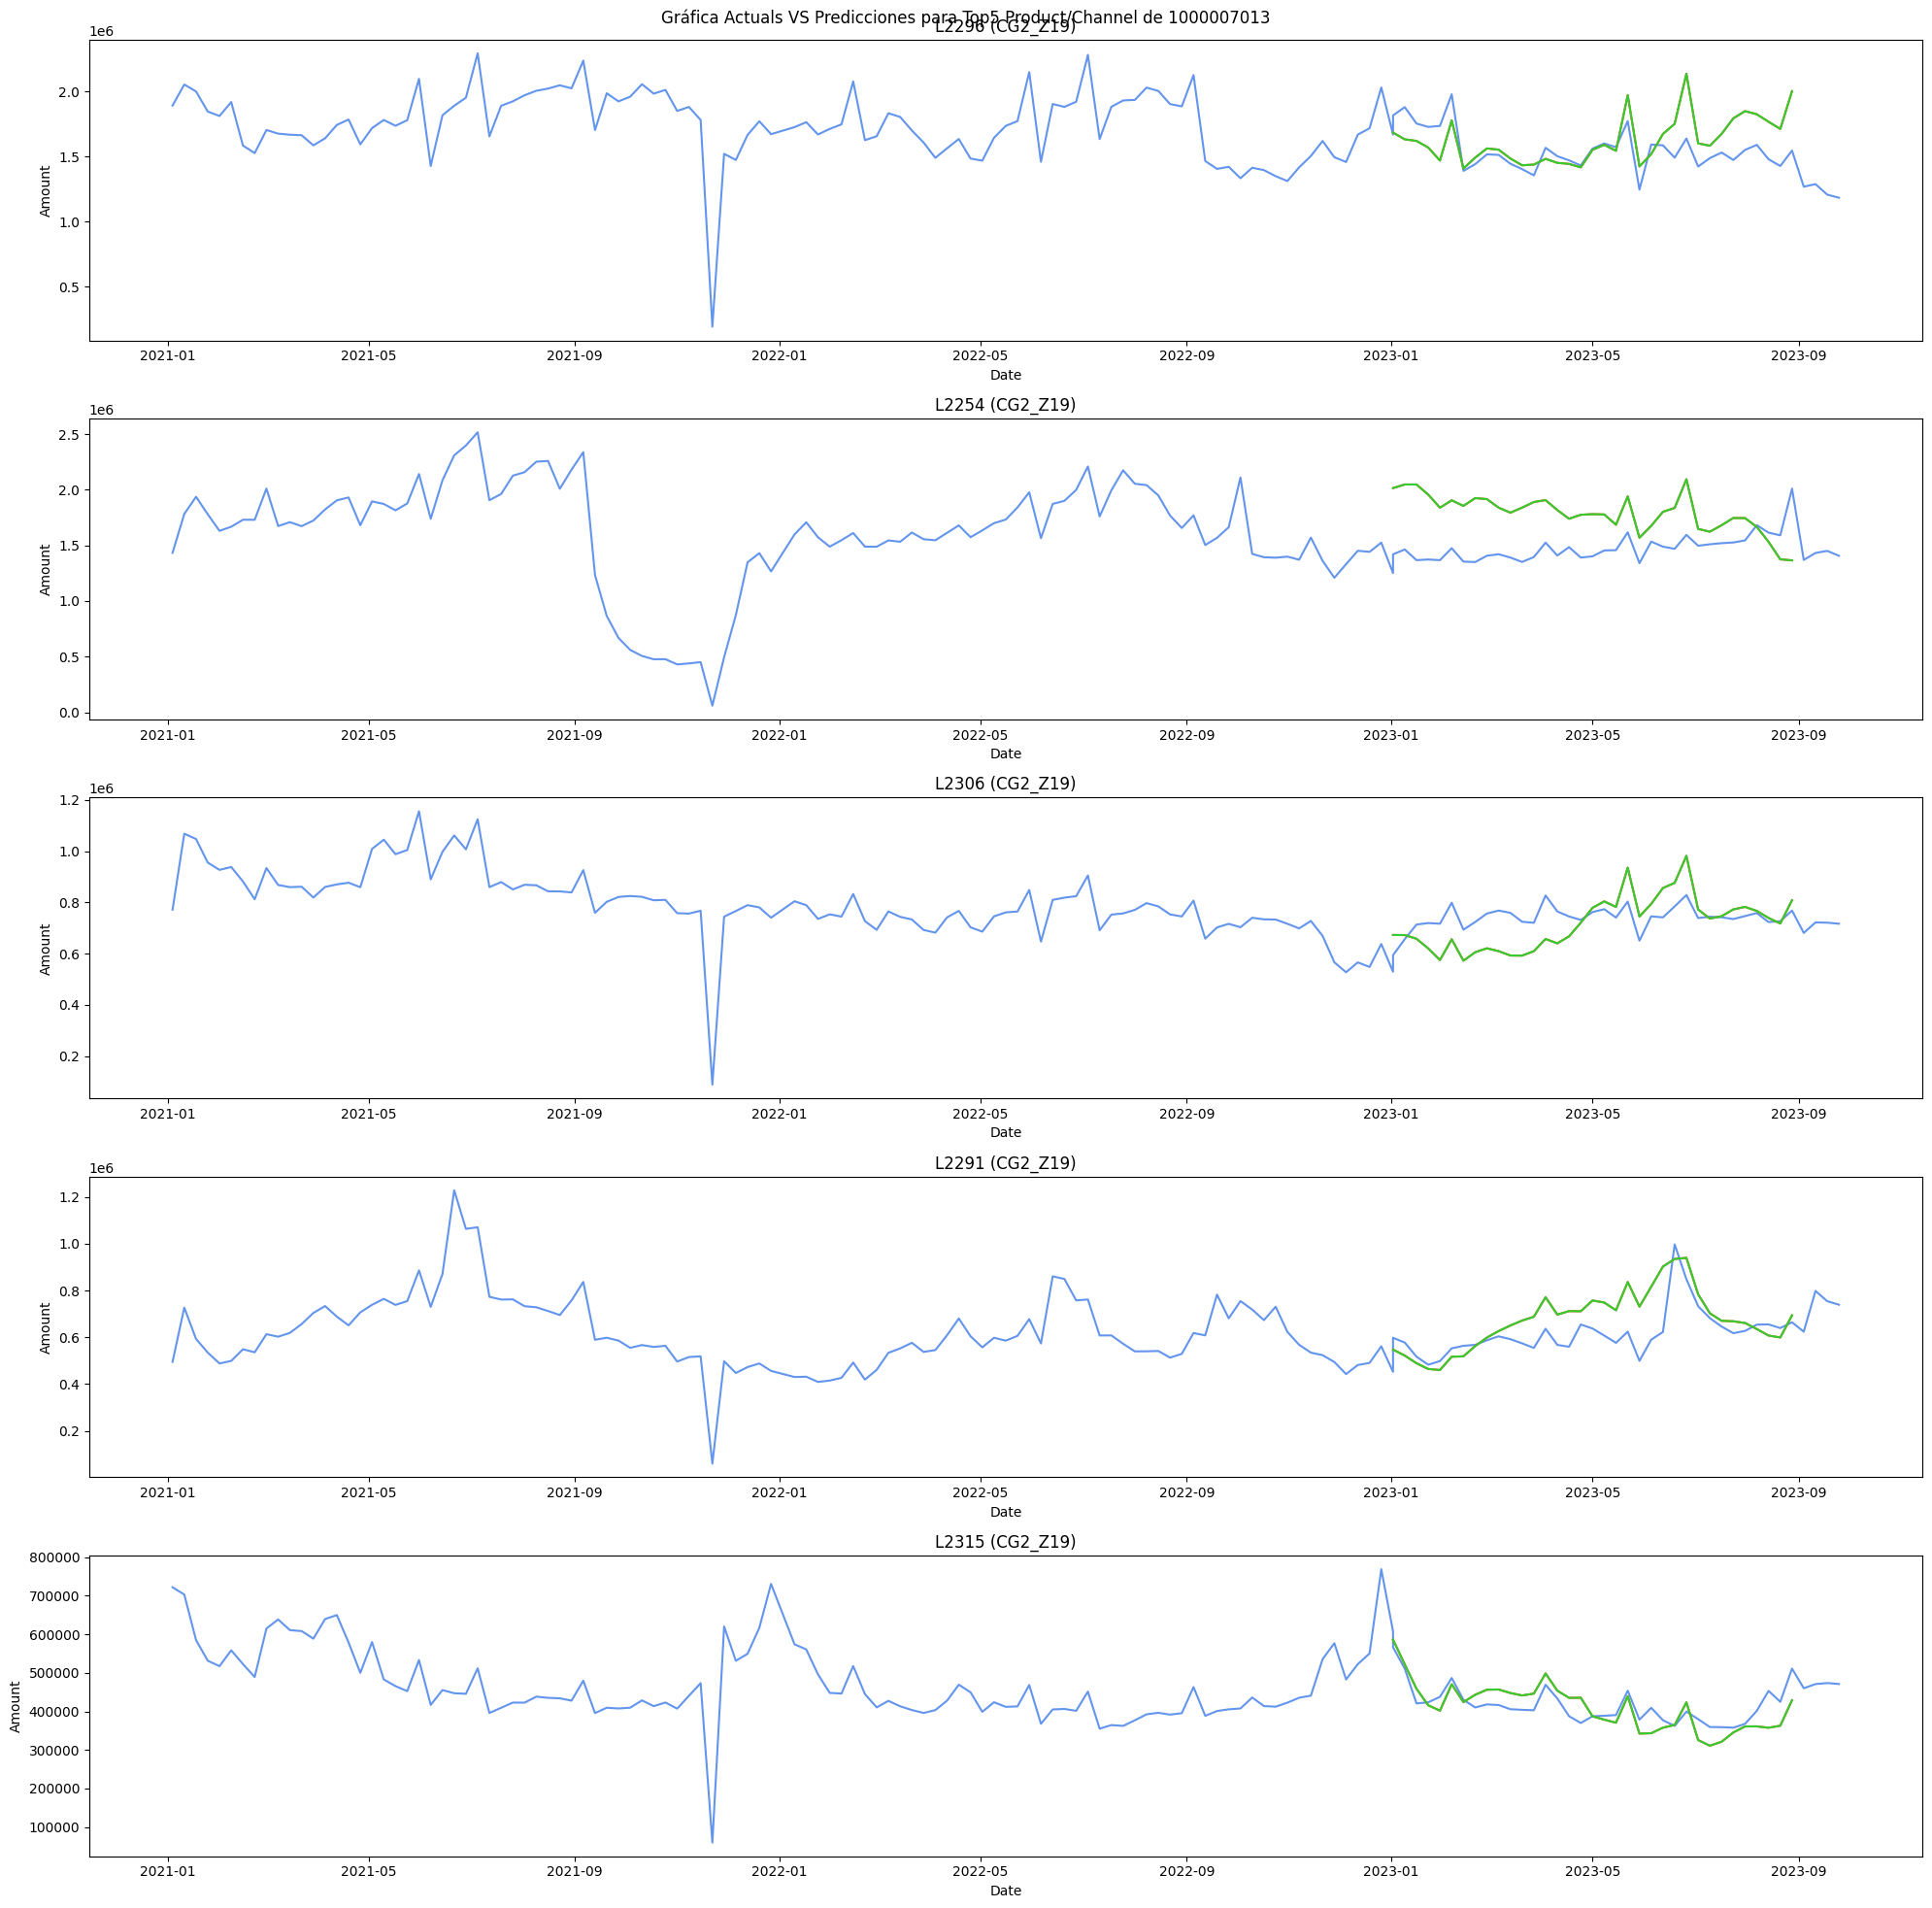

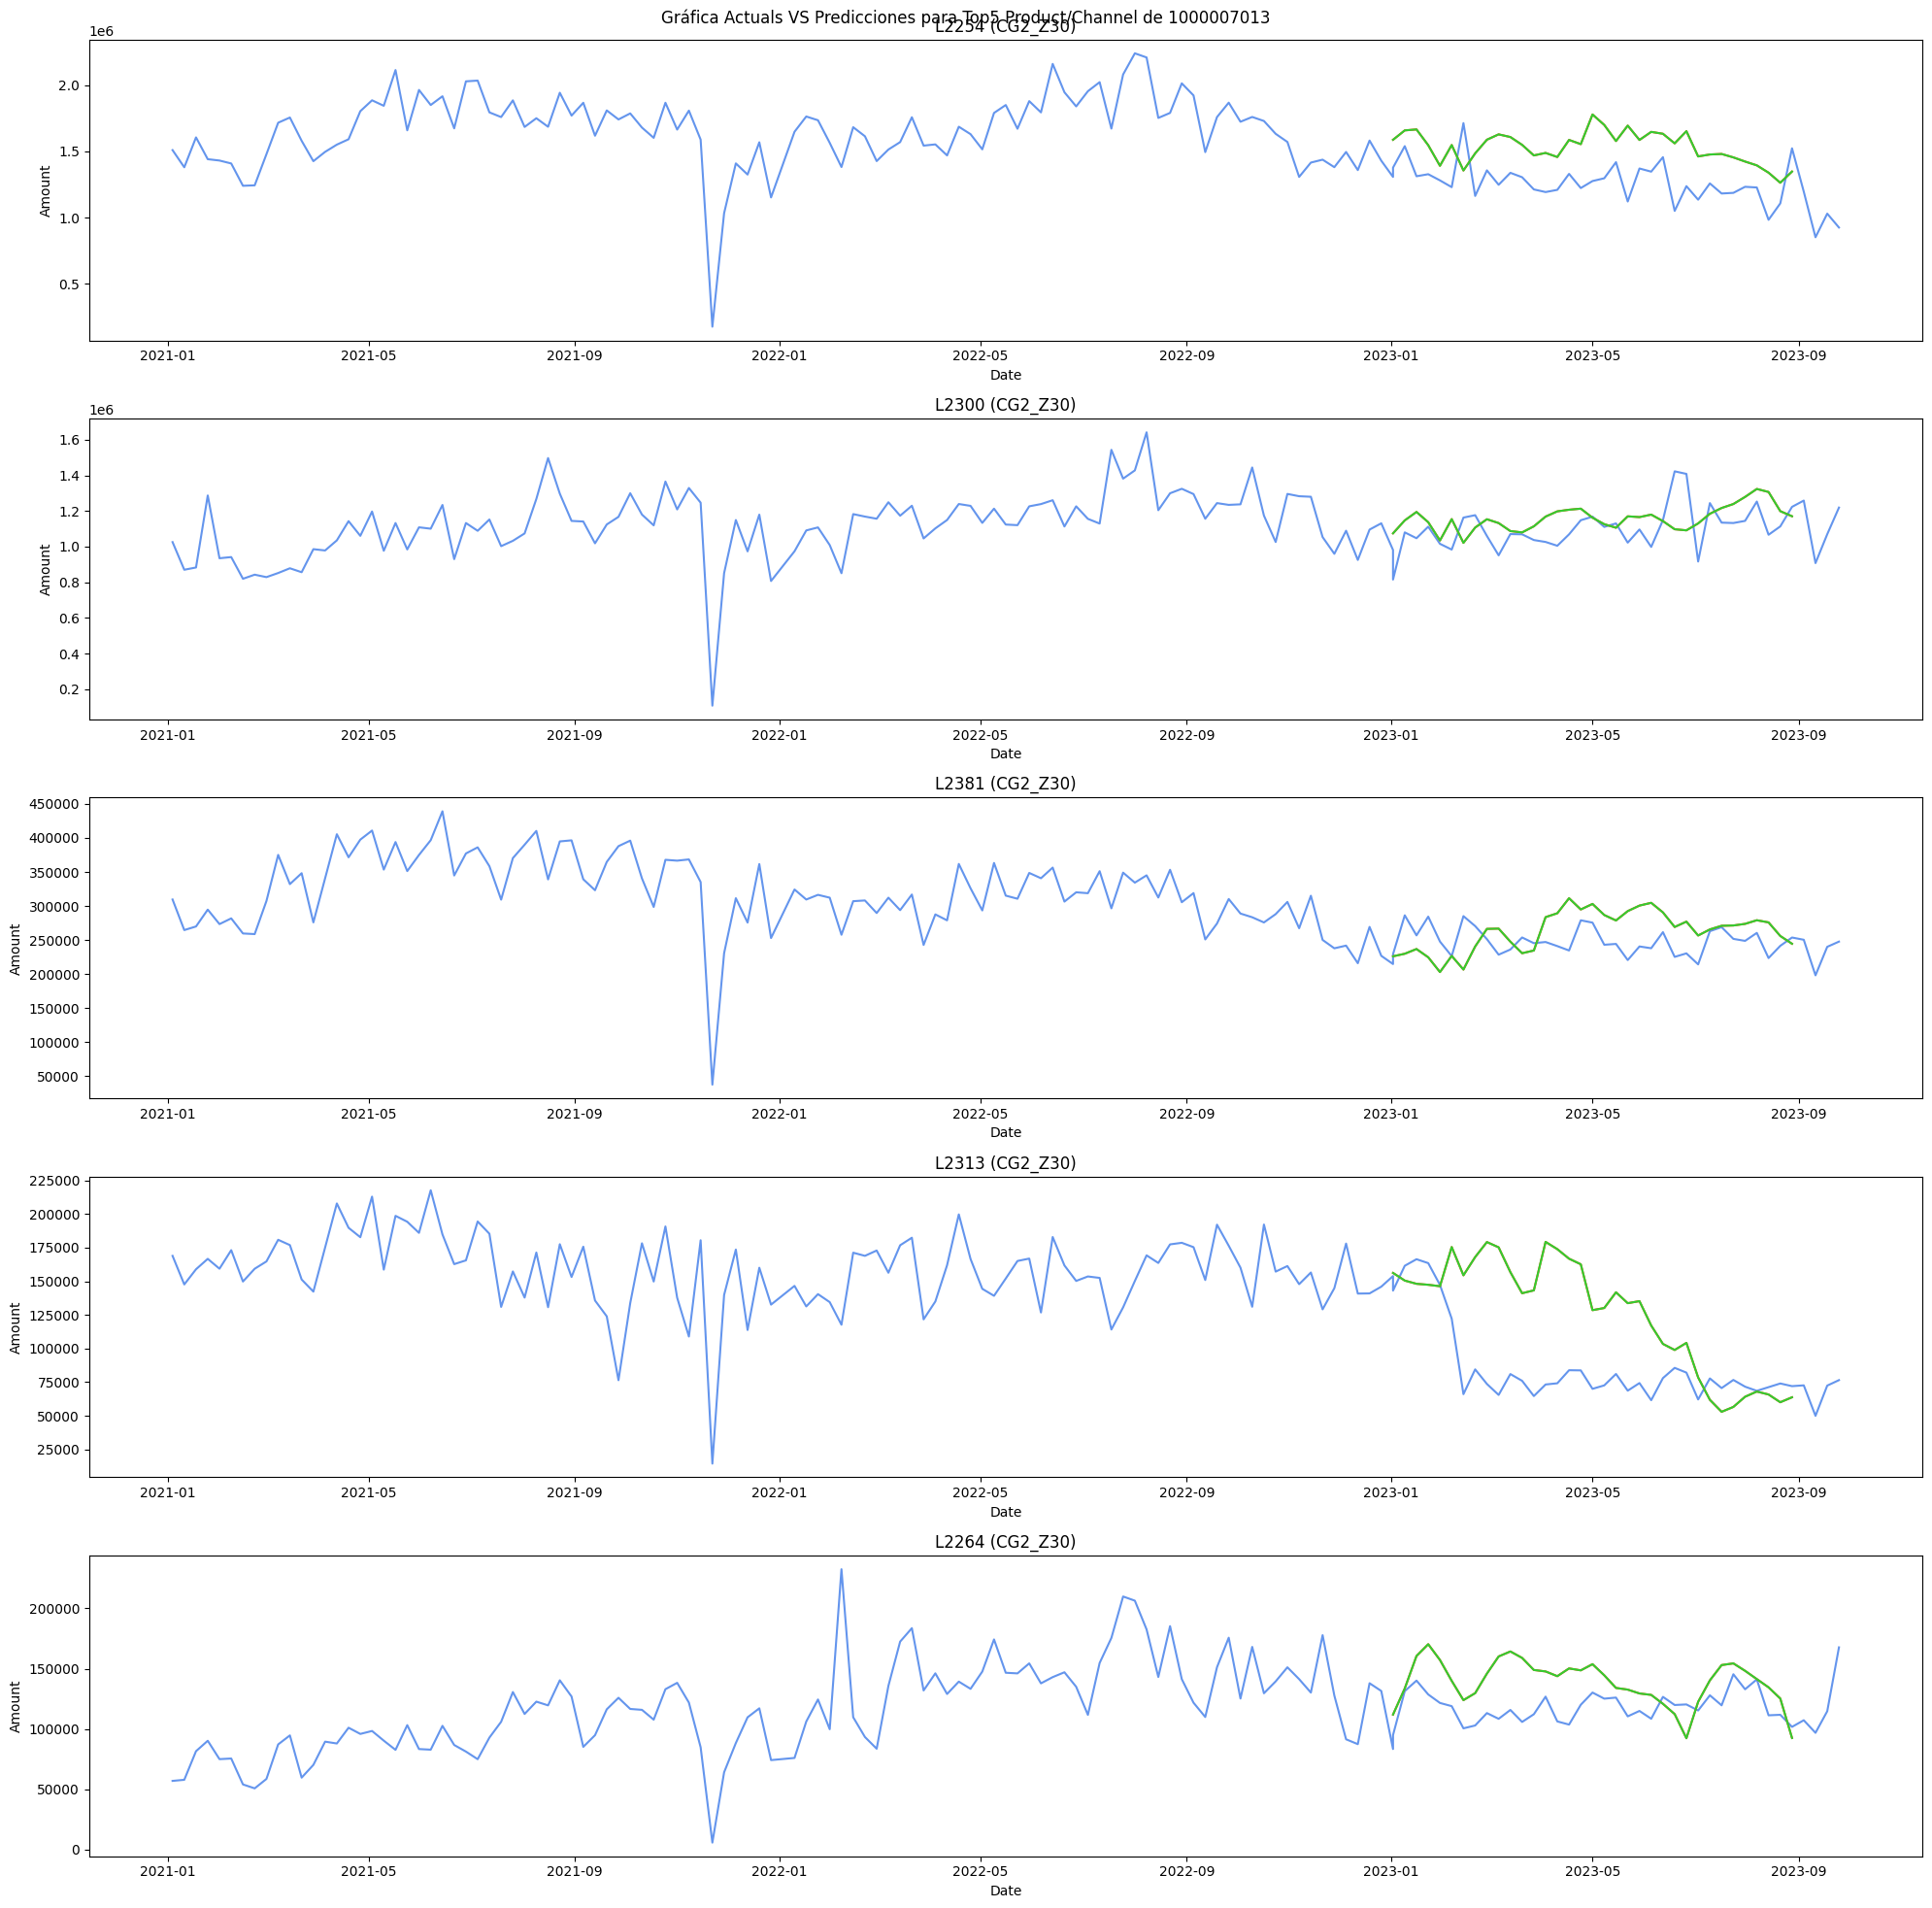

In [22]:
for i in range(len(topcustomers)):

    # Crear subplots para cada cliente
    num_plots = len(unique_customers)
    cols = 1  # Número de columnas en la disposición de subplots
    rows = 5  # Cálculo del número de filas necesarias
    fig, axs = plt.subplots(rows, cols, figsize=(20, 20))
    fig.suptitle(f'Gráfica Actuals VS Predicciones para Top5 Product/Channel de {customer}')

    for j in range(len(topproducts)):
      row = i // cols
      data_actual = df_actual[(df_actual['CUSTOMER'] == topcustomers[i]) & (df_actual['PRODUCT'] == topproducts[i][j]) & (df_actual['SEGMENT/CHANNEL'] == topchanels[i][j])].sort_values(by=['YEAR', 'WEEK'], ascending=[True, True])
      data_actual = data_actual.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT','YEAR','WEEK'])['AMOUNT'].sum().reset_index()
      datax = merged_amounts[(merged_amounts['CUSTOMER'] == topcustomers[i]) & (merged_amounts['PRODUCT'] == topproducts[i][j]) & (merged_amounts['SEGMENT/CHANNEL'] == topchanels[i][j])].sort_values(by=['YEAR', 'WEEK'], ascending=[True, True])

      ax = axs[j]

      data_actual['date'] = pd.to_datetime(data_actual['YEAR'].astype(str) + data_actual['WEEK'].astype(str) + '1', format='%Y%W%w')
      datax['date'] = pd.to_datetime(datax['YEAR'].astype(str) + datax['WEEK'].astype(str) + '1', format='%Y%W%w')

      #Diagrama de barras
      ax.plot(data_actual['date'], data_actual['AMOUNT'], label='Actual', color='cornflowerblue')
      ax.plot(datax['date'], datax['AMOUNT_DIV_0'], label='Model 0', color='orangered')
      ax.plot(datax['date'], datax['AMOUNT_DIV_1'], label='Model 1', color='limegreen')
      ax.set_title(f'{topproducts[i][j]} ({topchanels[i][j]})')
      ax.set_xlabel('Date')
      ax.set_ylabel('Amount')

    plt.tight_layout()
    plt.show()
    print('')
    print('')

Ahora, continuemos con el cálculo de los errores cuadráticos medios. Para ello realizamos los mismos bucles que para graficar. Sin embargo, en vez de plotear filtramos el dataframe creado anteriormente mediante inner joins y con la función de ```mean_squared_error``` de sklearn realizamos el error cuadrático medio comparando tanto actuals con modelo 0 como con modelo 1. Además guardamos los 3 errores mínimos para cada cliente. Guardamos tres y no dos porque, como hemos mencionado anteriormente, los modelos 0 y 1 son iguales por lo que el top 1 y 2 serán los dos modelos para la misma combinación. Es por eso que nos quedaremos con top 1 y top 3.



In [45]:
min_combinations_1 = []
min_mses_1 = []
min_combinations_2 = []
min_mses_2 = []
min_combinations_3 = []
min_mses_3 = []
mses_client = []
for i in range(len(topcustomers)):
  min_combination_1 = None
  min_mse_1 = float('inf')
  min_combination_2 = None
  min_mse_2 = float('inf')
  min_combination_3 = None
  min_mse_3 = float('inf')
  print('-------------------------------------------------------')
  print(f'ERRORES CUADRÁTICOS MEDIOS CLIENTE: {topcustomers[i]}')
  for j in range(len(topproducts)):
    datax = merged_amounts[(merged_amounts['CUSTOMER'] == topcustomers[i]) & (merged_amounts['PRODUCT'] == topproducts[i][j]) & (merged_amounts['SEGMENT/CHANNEL'] == topchanels[i][j])].sort_values(by=['YEAR', 'WEEK'], ascending=[True, True])
    mse0 = mean_squared_error(datax['AMOUNT_DIV_0'],datax['AMOUNT_REAL'])
    mse1 = mean_squared_error(datax['AMOUNT_DIV_1'],datax['AMOUNT_REAL'])
    print('')
    print(f'Product {topproducts[i][j]} // Channel {topchanels[i][j]}')
    print(f"- Mean Squared Error Model 0: {mse0}")
    print(f"- Mean Squared Error Model 1: {mse1}")

    if mse0 < min_mse_1:
        min_combination_3 = min_combination_2
        min_mse_3 = min_mse_2
        min_combination_2 = min_combination_1
        min_mse_2 = min_mse_1
        min_combination_1 = (topcustomers[i], topproducts[i][j], topchanels[i][j], 0)
        min_mse_1 = mse0
    elif mse0 < min_mse_2:
        min_combination_3 = min_combination_2
        min_mse_3 = min_mse_2
        min_combination_2 = (topcustomers[i], topproducts[i][j], topchanels[i][j], 0)
        min_mse_2 = mse0
    elif mse0 < min_mse_3:
        min_combination_3 = (topcustomers[i], topproducts[i][j], topchanels[i][j], 0)
        min_mse_3 = mse0

    if mse1 < min_mse_1:
        min_combination_3 = min_combination_2
        min_mse_3 = min_mse_2
        min_combination_2 = min_combination_1
        min_mse_2 = min_mse_1
        min_combination_1 = (topcustomers[i], topproducts[i][j], topchanels[i][j], 1)
        min_mse_1 = mse1
    elif mse1 < min_mse_2:
        min_combination_3 = min_combination_2
        min_mse_3 = min_mse_2
        min_combination_2 = (topcustomers[i], topproducts[i][j], topchanels[i][j], 1)
        min_mse_2 = mse1
    elif mse1 < min_mse_3:
        min_combination_3 = (topcustomers[i], topproducts[i][j], topchanels[i][j], 1)
        min_mse_3 = mse1

  min_combinations_1.append(min_combination_1)
  min_combinations_2.append(min_combination_2)
  min_combinations_3.append(min_combination_3)
  min_mses_1.append(min_mse_1)
  min_mses_2.append(min_mse_2)
  min_mses_3.append(min_mse_3)
  print('')
  print('TOP 2 ERRORES CUADRÁTICOS MÍNIMOS:')
  print(f'1· {min_combination_1[0]} ({min_combination_1[1]} // {min_combination_1[2]} // Model {min_combination_1[3]}): {min_mse_1}')
  print(f'2· {min_combination_3[0]} ({min_combination_3[1]} // {min_combination_3[2]} // Model {min_combination_3[3]}): {min_mse_3}')
  print('',end='\n')
  print('',end='\n')




-------------------------------------------------------
ERRORES CUADRÁTICOS MEDIOS CLIENTE: AO_FTN_US

Product L2481 // Channel 2FS
- Mean Squared Error Model 0: 10476583913.015175
- Mean Squared Error Model 1: 10476583913.015177

Product L2481 // Channel ZZ_FSV_FTN_US
- Mean Squared Error Model 0: 17028369650.436907
- Mean Squared Error Model 1: 17028369650.436907

Product L2481 // Channel CG3_Z24
- Mean Squared Error Model 0: 1331785203476.3667
- Mean Squared Error Model 1: 1331785203476.3667

Product L2481 // Channel CG3_Z49
- Mean Squared Error Model 0: 4900693913.316167
- Mean Squared Error Model 1: 4900693913.316167

Product L2481 // Channel CG3_Z81
- Mean Squared Error Model 0: 1006221422.0902357
- Mean Squared Error Model 1: 1006221422.0902355

TOP 2 ERRORES CUADRÁTICOS MÍNIMOS:
1· AO_FTN_US (L2481 // CG3_Z81 // Model 1): 1006221422.0902355
2· AO_FTN_US (L2481 // CG3_Z49 // Model 0): 4900693913.316167


-------------------------------------------------------
ERRORES CUADRÁTICOS

Además, graficamos los errores cuadráticos medios de cada uno de los modelos de cada cliente en paralelo de forma que podamos compararlos entre ellos (dentro de un mismo cliente). El límite ymax se establece como el máximo*1.125 dentro de los errores de un mismo cliente.

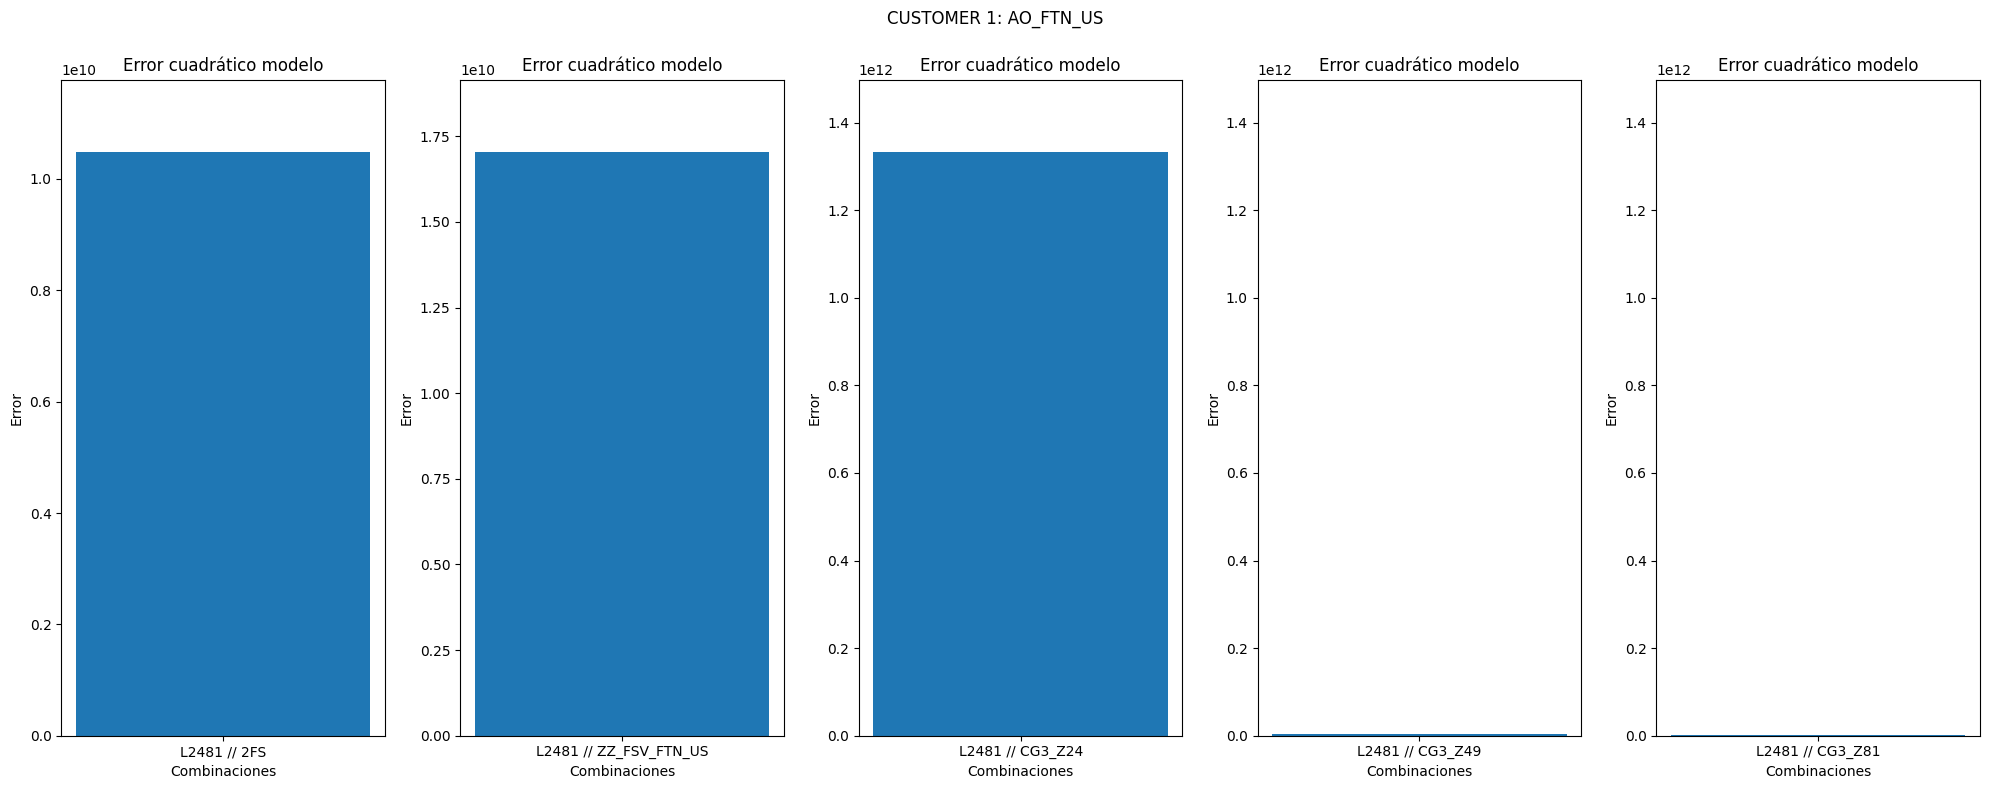

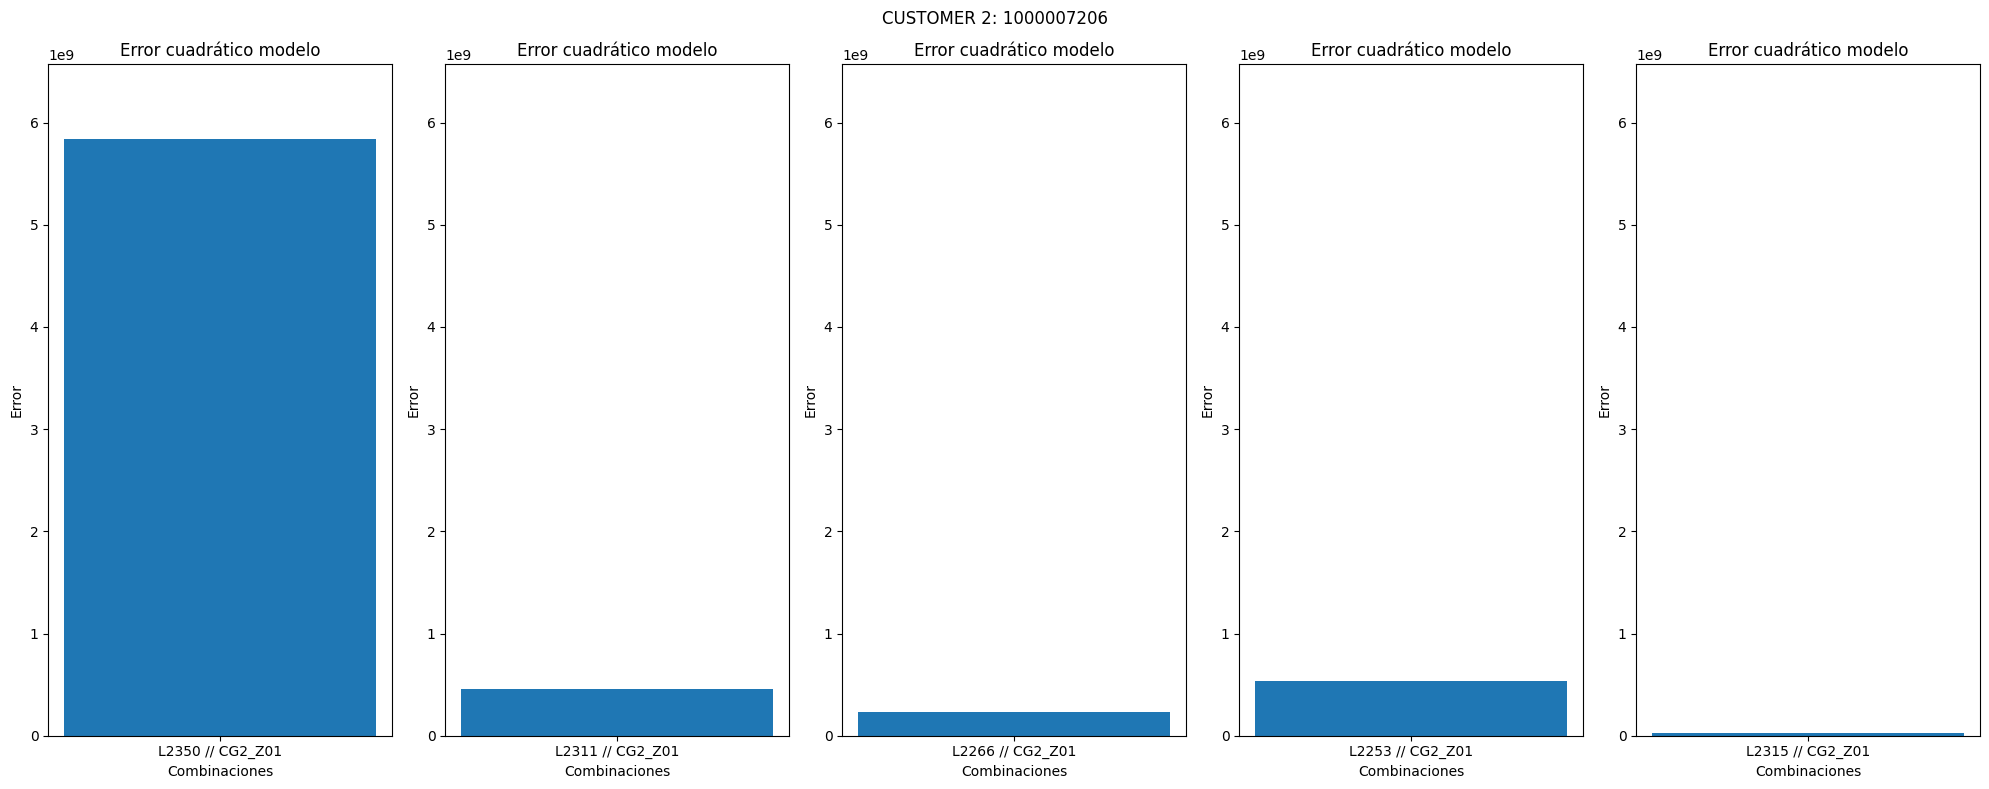

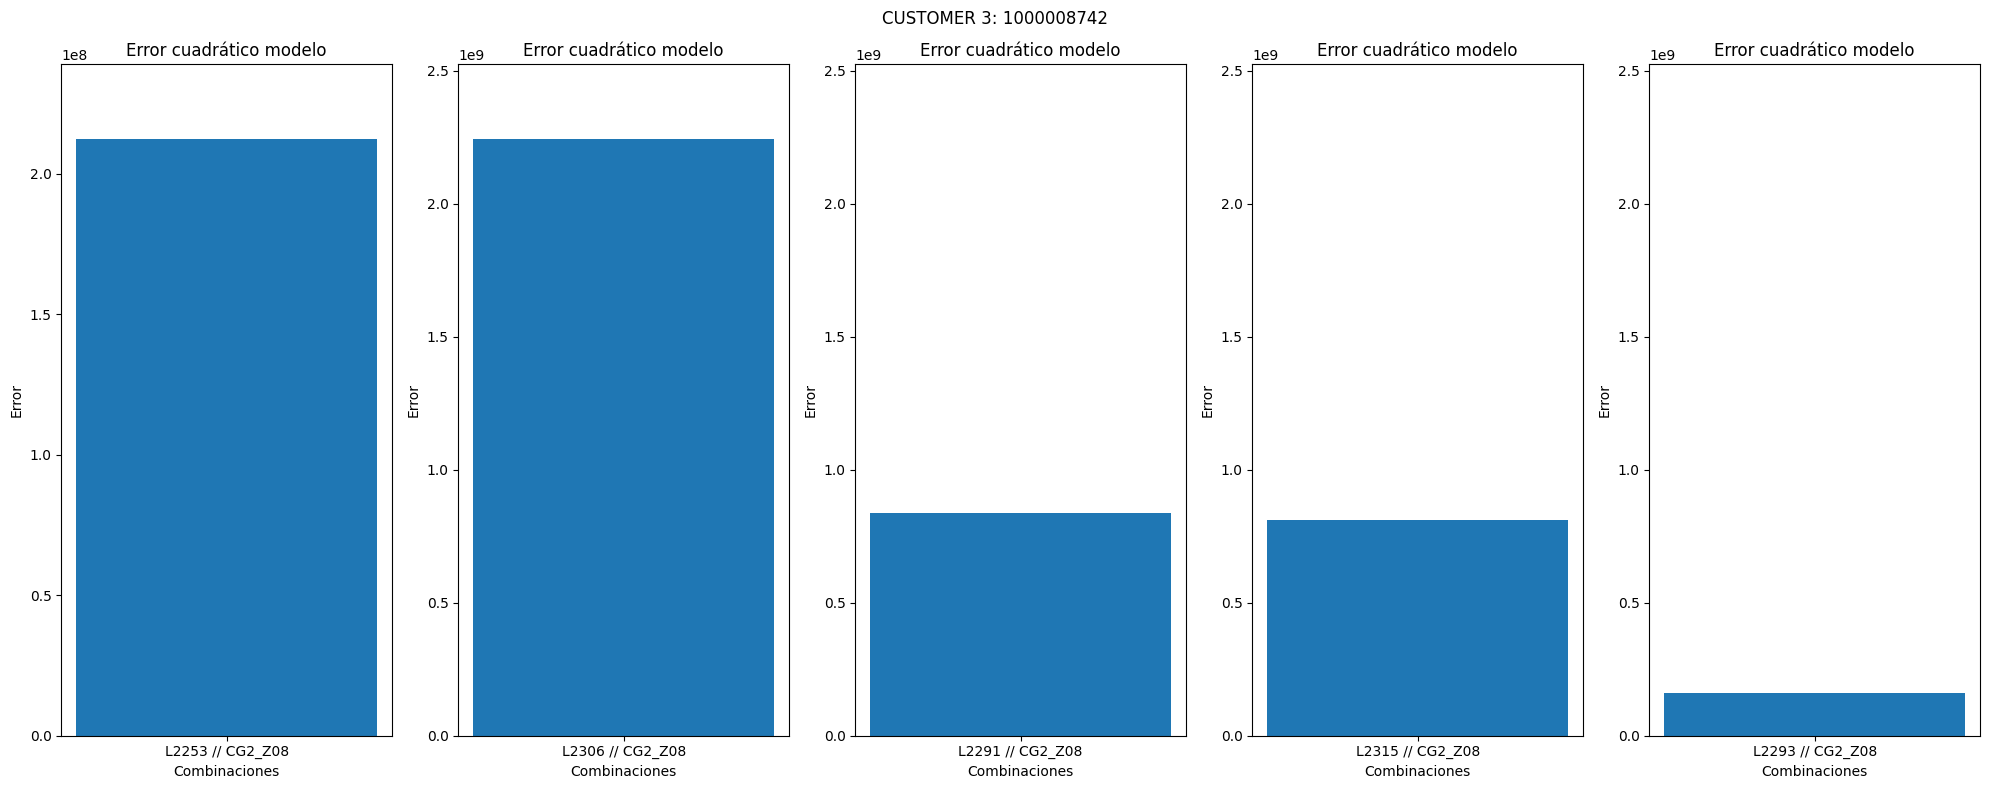

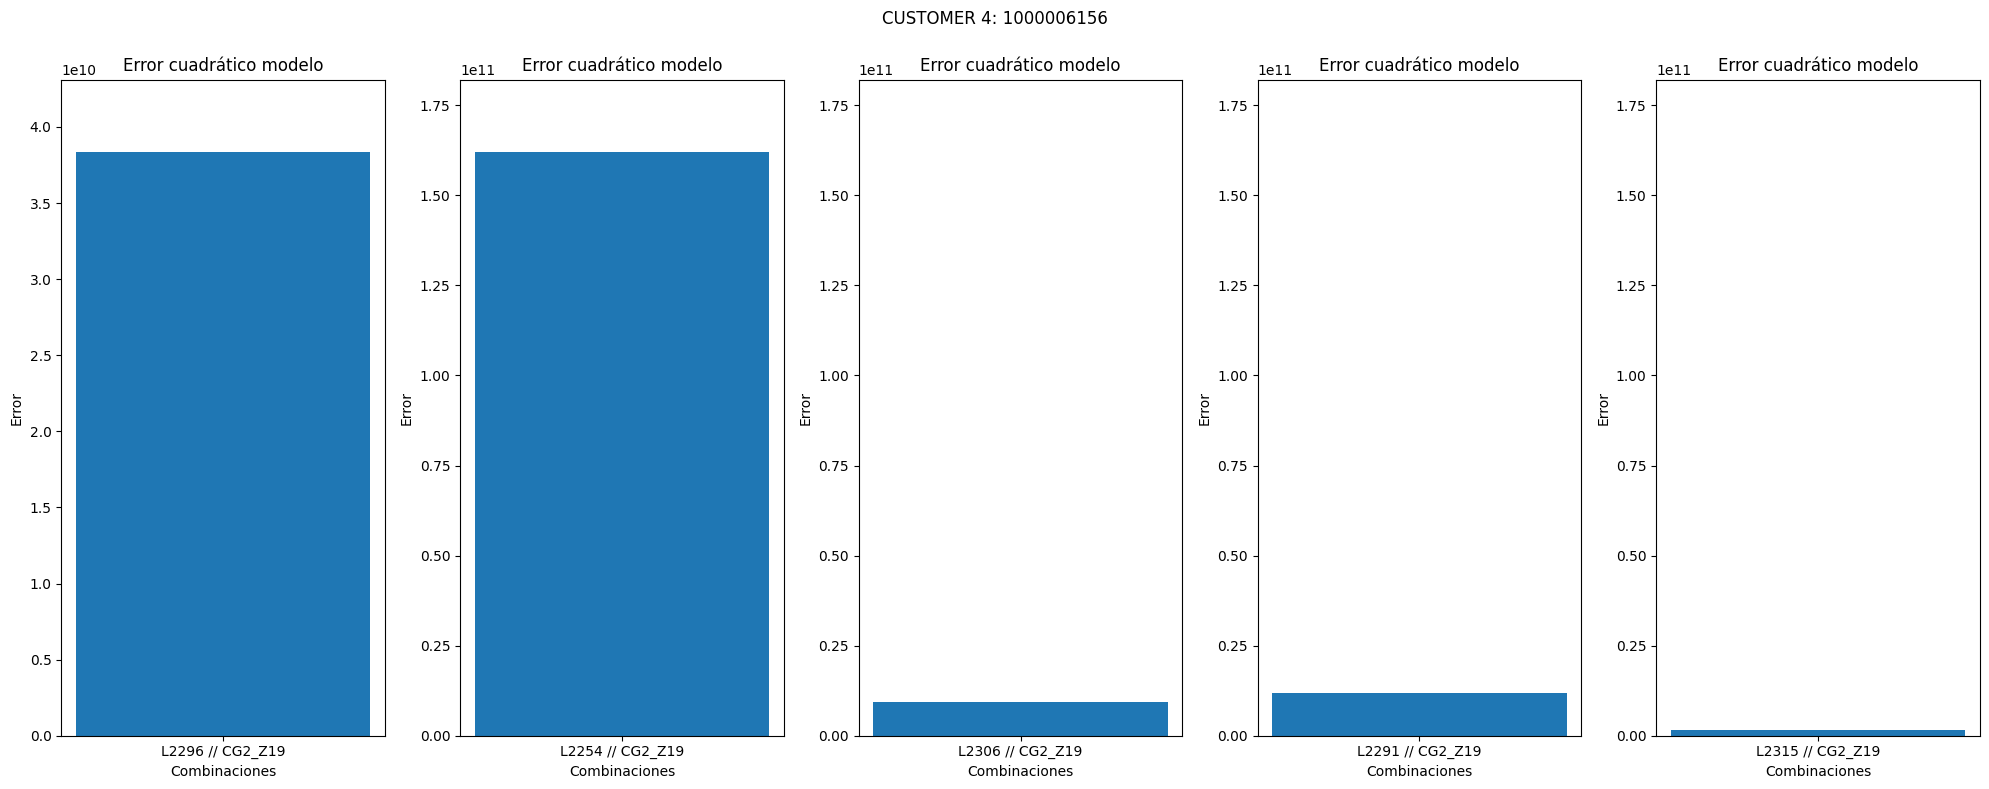

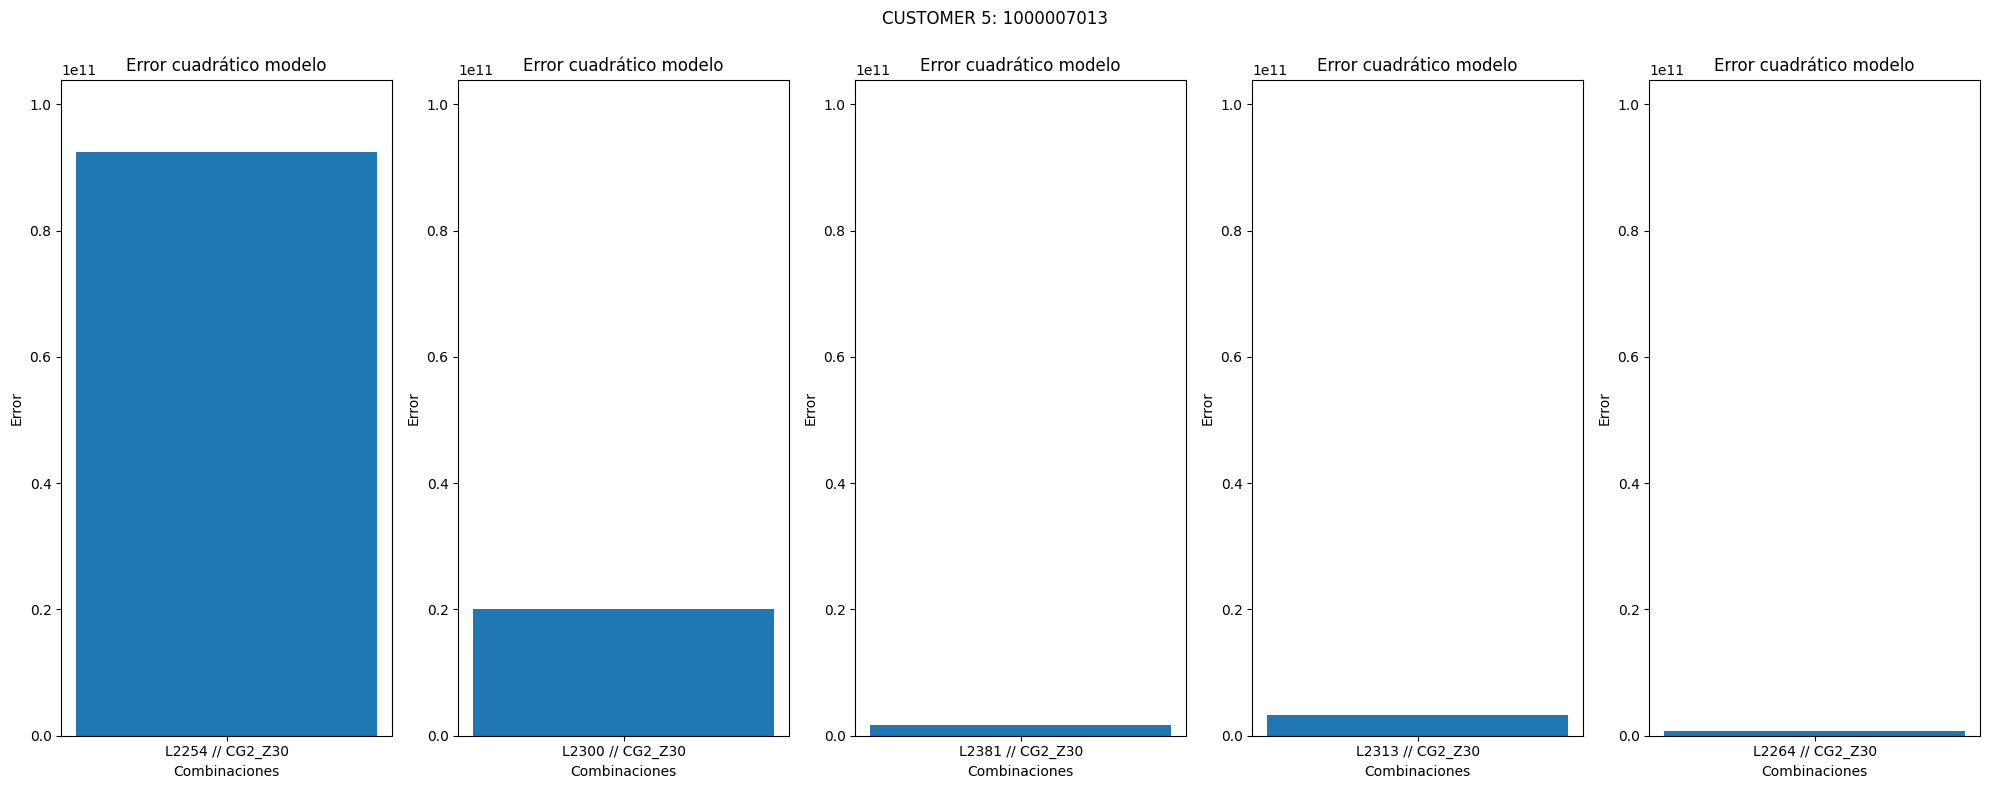

In [49]:
for i in range(len(topcustomers)):
  fig, axs = plt.subplots(1, 5, figsize=(20, 8))
  ymaxmax = 0
  for j in range(len(topproducts[0])):
    datax = merged_amounts[(merged_amounts['CUSTOMER'] == topcustomers[i]) & (merged_amounts['PRODUCT'] == topproducts[i][j]) & (merged_amounts['SEGMENT/CHANNEL'] == topchanels[i][j])].sort_values(by=['YEAR', 'WEEK'], ascending=[True, True])
    mse0 = mean_squared_error(datax['AMOUNT_DIV_0'],datax['AMOUNT_REAL'])
    mse1 = mean_squared_error(datax['AMOUNT_DIV_1'],datax['AMOUNT_REAL'])

    if mse0>ymaxmax:
      ymaxmax = mse0

    print('')

    axs[j].plot()
    axs[j].bar([f'{topproducts[i][j]} // {topchanels[i][j]}'], [mse0])
    axs[j].set_title('Error cuadrático modelo')
    axs[j].set_xlabel('Combinaciones')
    axs[j].set_ylabel('Error')
    axs[j].set_ylim(0, ymaxmax*1.125)

  plt.suptitle(f'CUSTOMER {i+1}: {topcustomers[i]}')
  plt.tight_layout()
  plt.show()
  print('')
  print('')

##Pregunta 3
*¿Cuáles son las previsiones de los 2 mejores modelos de cada customer de las series de la pregunta anterior?*
Para esto realizamos el mismo proceso que en el graficado de series anterior pero en vez de realizarlo para el top 5 combinaciones de cada customer lo realizamos para las dos series con menor error cuadrático de cada cliente, almacenados en unas variables creadas y rellenadas en el cálculo del mse. Además, se muestra una comparativa de los errores cuadráticos de los 2 mínimos de cada cliente en un diagrama de barras para ver la diferencia visualmente. Todos los errores cuadráticos se muestran en la misma escala del eje y para poder bservar bien las diferencias entre errores cuadráticos de diferentes clientes

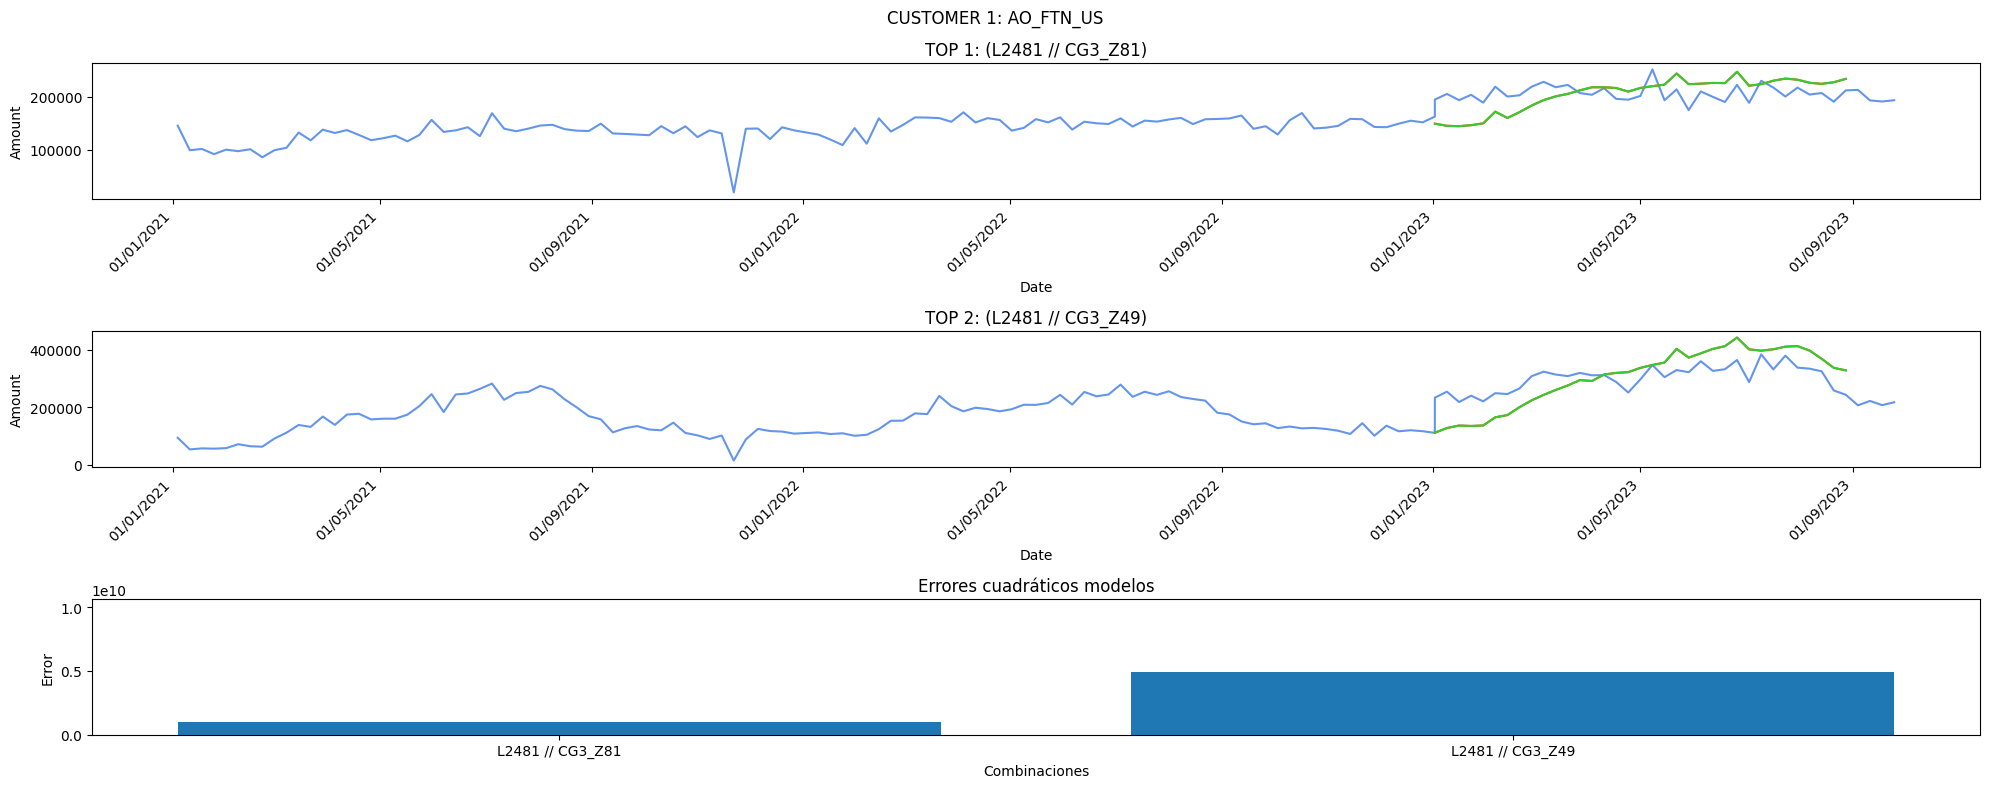

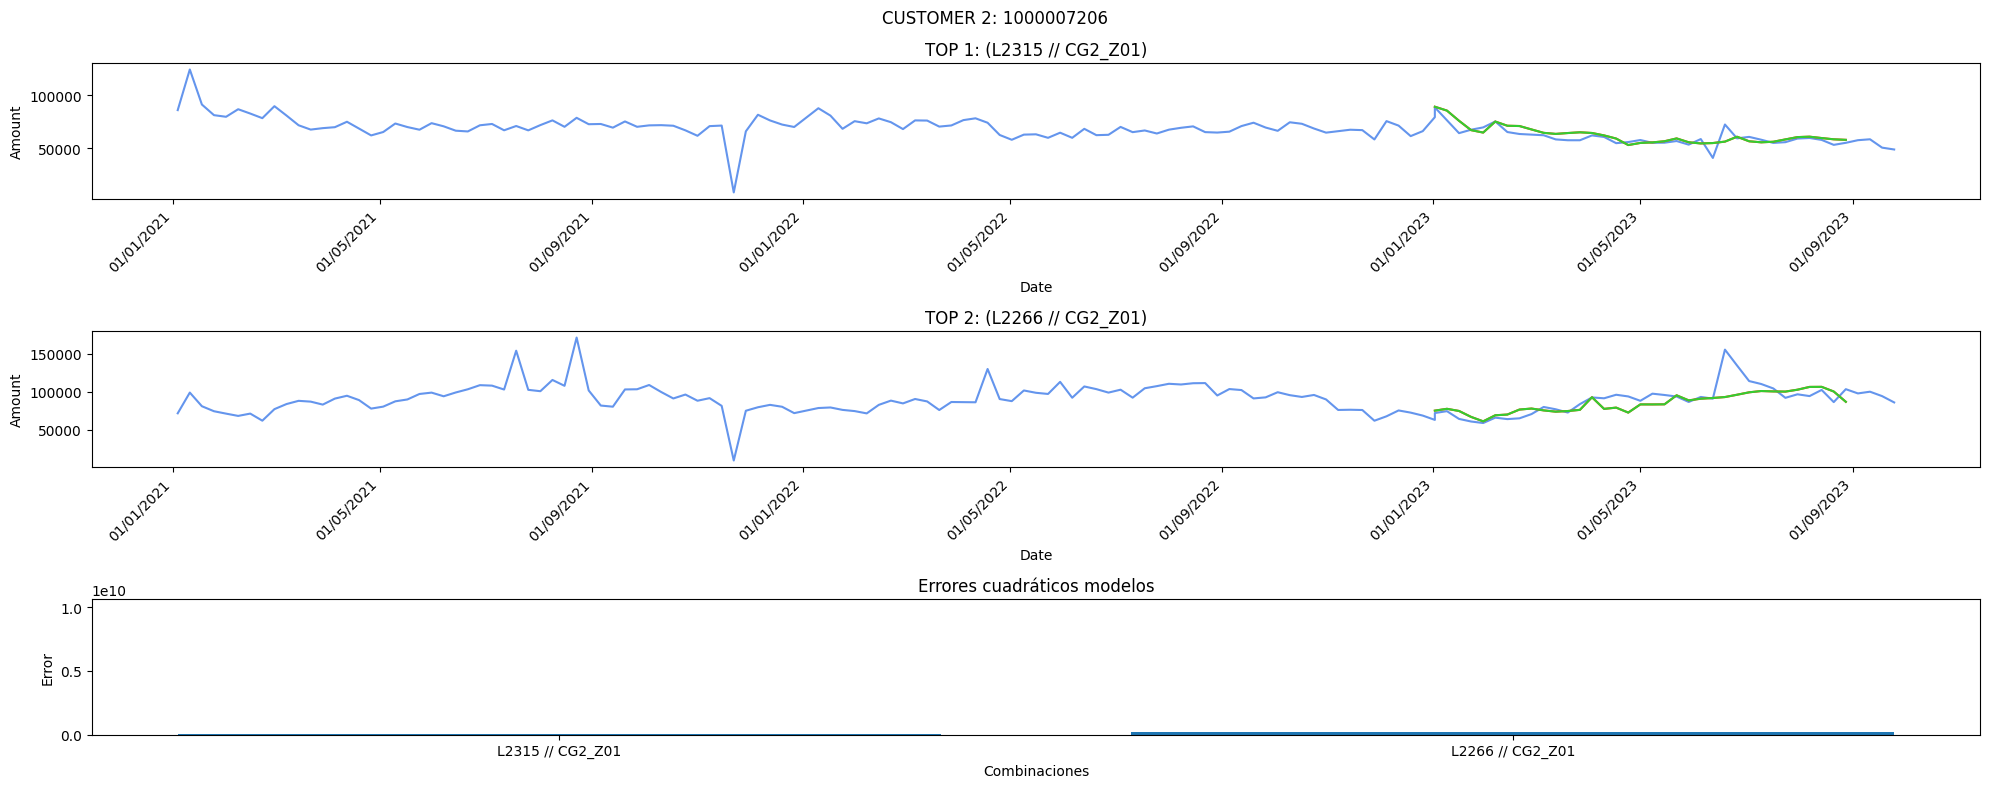

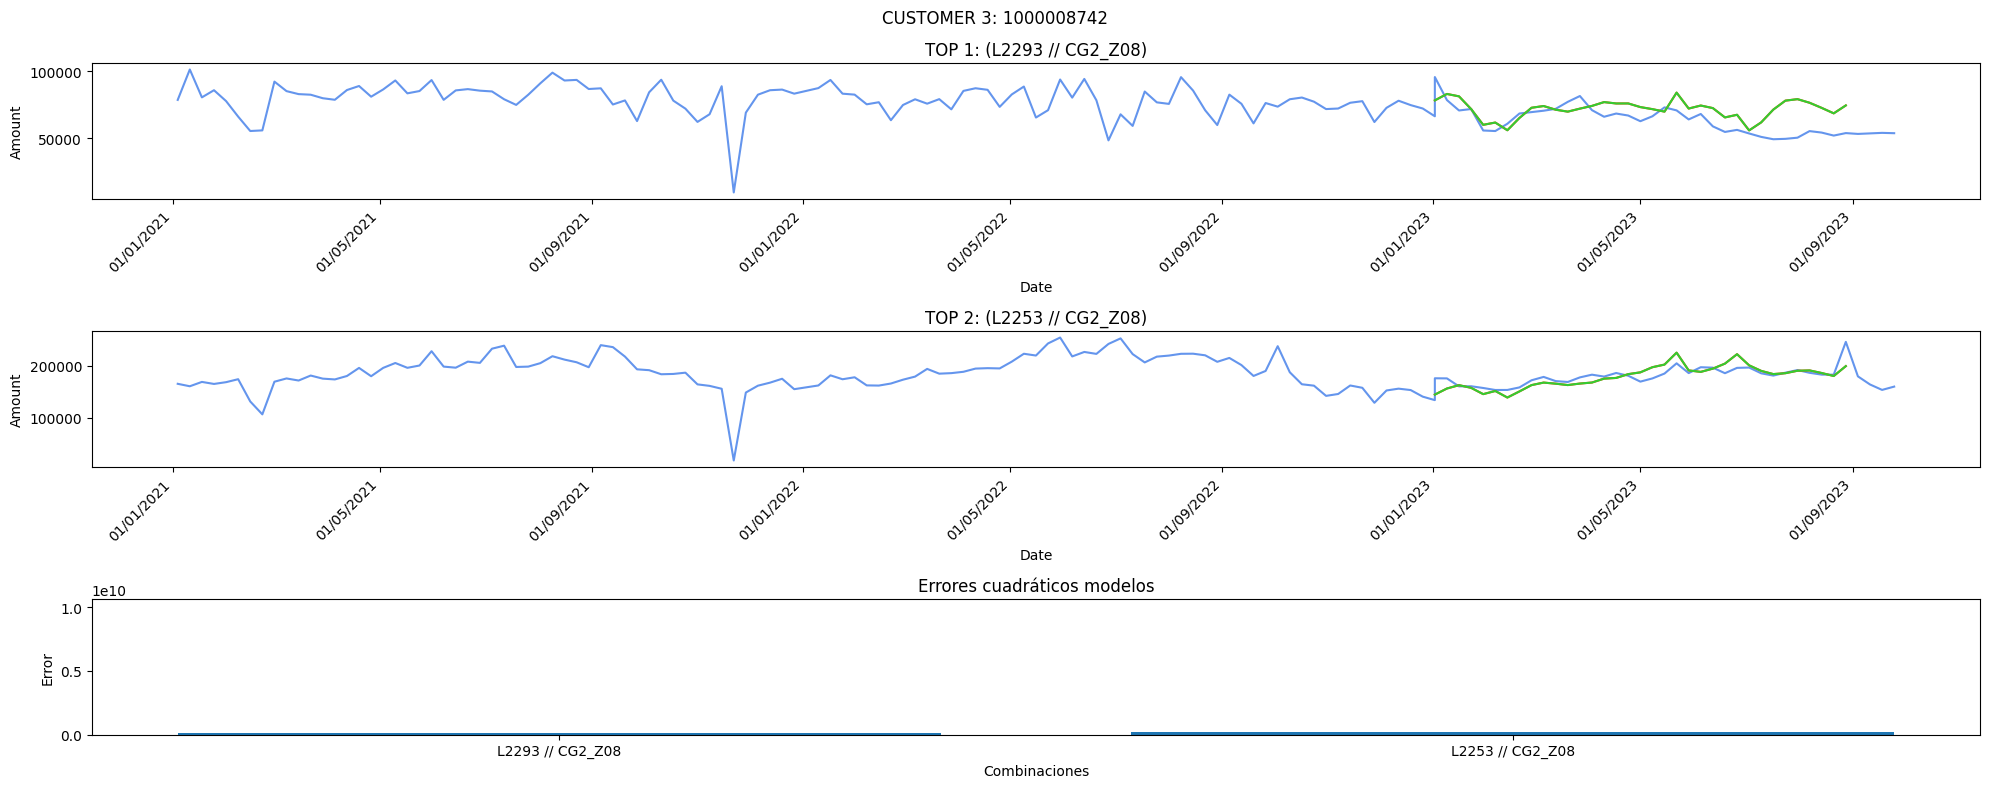

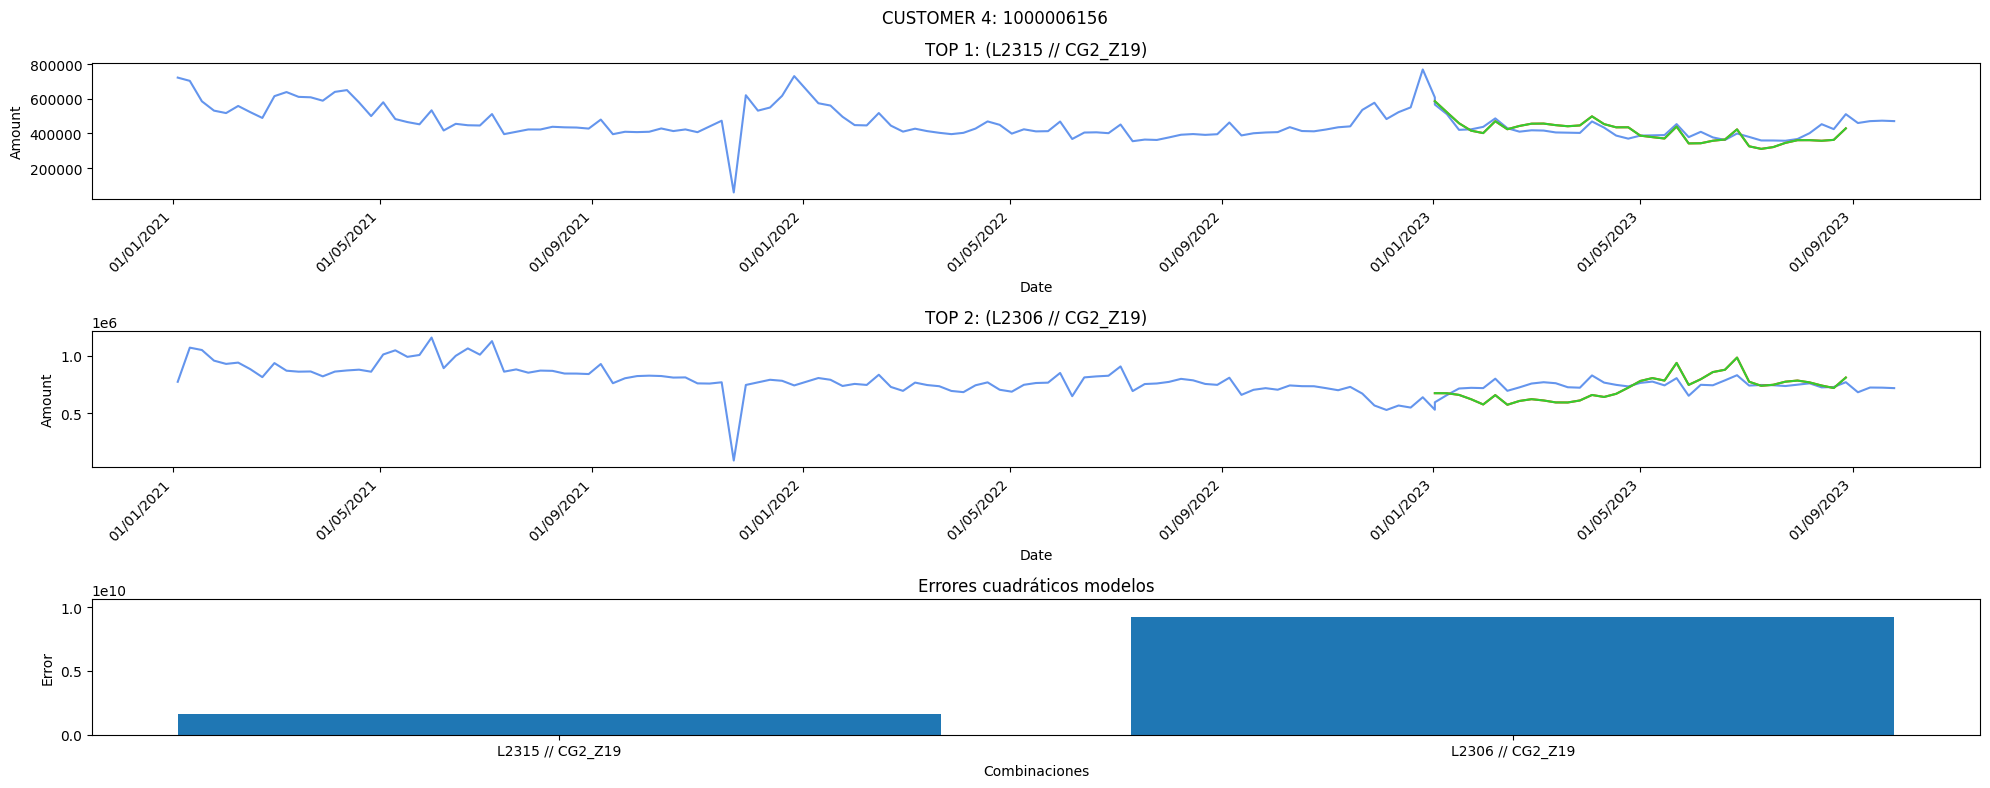

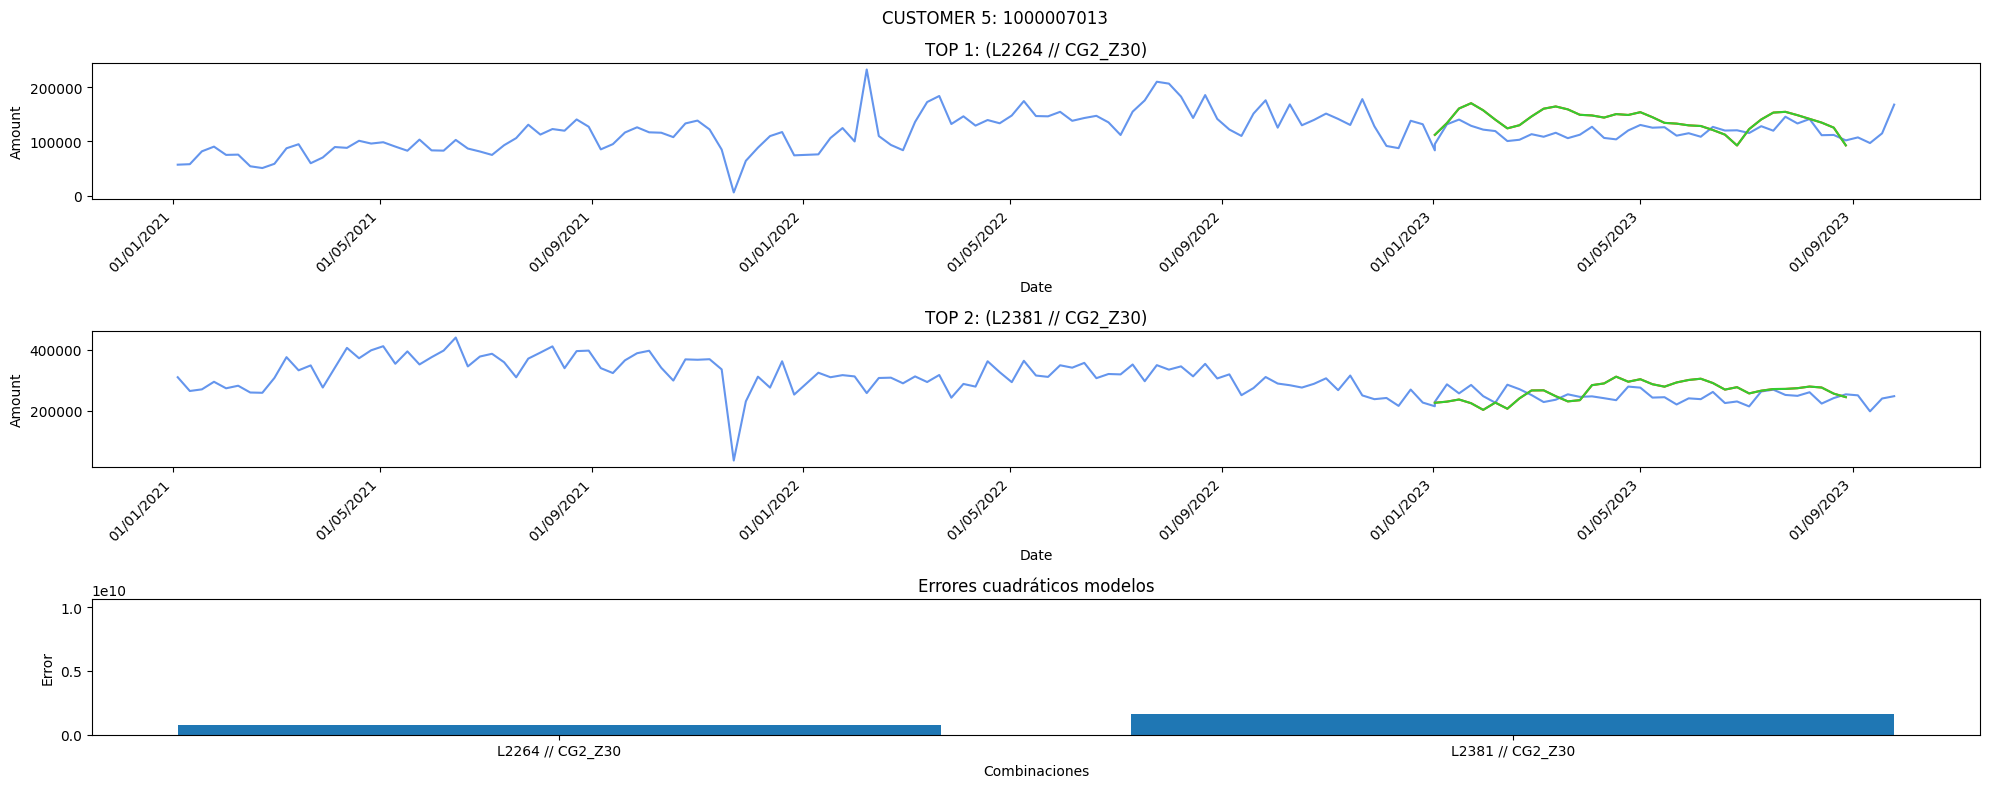

In [37]:
import matplotlib.dates as mdates
import warnings
date_formatter = mdates.DateFormatter('%d/%m/%Y')
warnings.filterwarnings("ignore", category=UserWarning)
ymin = 0
ymax = max(max(min_mses_1),max(min_mses_3))
ymax = 1.15*ymax


for i in range(len(min_combinations_1)):
  fig, axs = plt.subplots(3, 1, figsize=(20, 8))
  data_actual = df_actual[(df_actual['CUSTOMER'] == min_combinations_1[i][0]) & (df_actual['PRODUCT'] == min_combinations_1[i][1]) & (df_actual['SEGMENT/CHANNEL'] == min_combinations_1[i][2])].sort_values(by=['YEAR', 'WEEK'], ascending=[True, True])
  data_actual = data_actual.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT','YEAR','WEEK'])['AMOUNT'].sum().reset_index()
  datax = merged_amounts[(merged_amounts['CUSTOMER'] == min_combinations_1[i][0]) & (merged_amounts['PRODUCT'] == min_combinations_1[i][1]) & (merged_amounts['SEGMENT/CHANNEL'] == min_combinations_1[i][2])].sort_values(by=['YEAR', 'WEEK'], ascending=[True, True])


  data_actual['date'] = pd.to_datetime(data_actual['YEAR'].astype(str) + data_actual['WEEK'].astype(str) + '1', format='%Y%W%w')
  datax['date'] = pd.to_datetime(datax['YEAR'].astype(str) + datax['WEEK'].astype(str) + '1', format='%Y%W%w')

  #Diagrama de barras
  axs[0].plot(data_actual['date'], data_actual['AMOUNT'], label='Actual', color='cornflowerblue')
  axs[0].plot(datax['date'], datax['AMOUNT_DIV_0'], label='Model 0', color='orangered')
  axs[0].plot(datax['date'], datax['AMOUNT_DIV_1'], label='Model 1', color='limegreen')
  axs[0].set_title(f'TOP 1: ({min_combinations_1[i][1]} // {min_combinations_1[i][2]})')
  axs[0].set_xticklabels(data_actual['date'], rotation=45, ha='right')
  axs[0].set_xlabel('Date')
  axs[0].set_ylabel('Amount')
  axs[0].xaxis.set_major_formatter(date_formatter)

  #--------------------------------------------------------------------------------

  data_actual = df_actual[(df_actual['CUSTOMER'] == min_combinations_3[i][0]) & (df_actual['PRODUCT'] == min_combinations_3[i][1]) & (df_actual['SEGMENT/CHANNEL'] == min_combinations_3[i][2])].sort_values(by=['YEAR', 'WEEK'], ascending=[True, True])
  data_actual = data_actual.groupby(['CUSTOMER', 'SEGMENT/CHANNEL', 'PRODUCT','YEAR','WEEK'])['AMOUNT'].sum().reset_index()
  datax = merged_amounts[(merged_amounts['CUSTOMER'] == min_combinations_3[i][0]) & (merged_amounts['PRODUCT'] == min_combinations_3[i][1]) & (merged_amounts['SEGMENT/CHANNEL'] == min_combinations_3[i][2])].sort_values(by=['YEAR', 'WEEK'], ascending=[True, True])


  data_actual['date'] = pd.to_datetime(data_actual['YEAR'].astype(str) + data_actual['WEEK'].astype(str) + '1', format='%Y%W%w')
  datax['date'] = pd.to_datetime(datax['YEAR'].astype(str) + datax['WEEK'].astype(str) + '1', format='%Y%W%w')

  #Diagrama de barras
  axs[1].plot(data_actual['date'], data_actual['AMOUNT'], label='Actual', color='cornflowerblue')
  axs[1].plot(datax['date'], datax['AMOUNT_DIV_0'], label='Model 0', color='orangered')
  axs[1].plot(datax['date'], datax['AMOUNT_DIV_1'], label='Model 1', color='limegreen')
  axs[1].set_title(f'TOP 2: ({min_combinations_3[i][1]} // {min_combinations_3[i][2]})')
  axs[1].set_xticklabels(data_actual['date'], rotation=45, ha='right')
  axs[1].set_xlabel('Date')
  axs[1].set_ylabel('Amount')
  axs[1].xaxis.set_major_formatter(date_formatter)


  #--------------------------------------------------------------------------------

  axs[2].plot()
  axs[2].bar([f'{min_combinations_1[i][1]} // {min_combinations_1[i][2]}', f'{min_combinations_3[i][1]} // {min_combinations_3[i][2]}'], [min_mses_1[i], min_mses_3[i]])
  axs[2].set_title('Errores cuadráticos modelos')
  axs[2].set_xlabel('Combinaciones')
  axs[2].set_ylabel('Error')
  axs[2].set_ylim(ymin, ymax)

  plt.suptitle(f'CUSTOMER {i+1}: {min_combinations_1[i][0]}')
  plt.tight_layout()
  plt.show()
  print('')
  print('')